# Modeling Baseline Pipeline for Phishing URL Detection

In this notebook, we build a full modeling pipeline for detecting phishing URLs.  
We start with a dataset that contains two columns: a **URL** and a **label** indicating whether the URL is **benign** or **phishing**.

While we use a well-known research dataset for this example (PhishStorm), **any dataset with labeled URLs** can be used — because **all features in this pipeline will be created from scratch** using custom Python functions.

PhishTank dataset is our addditioonal dataset. It has 50K additional phishing links. 

📘 **Datasets citation**:  

> [1] S. Marchal, J. Francois, R. State, and T. Engel.  
> *PhishStorm: Detecting Phishing with Streaming Analytics*.  
> IEEE Transactions on Network and Service Management (TNSM), 11(4):458–471, 2014.

> PhishTank: https://phishtank.org/developer_info.php (dowloaded on Oct 4th 2025, the dataset is updated every day but we will use Oct 4th version)

> Alexa 1 million TOP popular domains: https://www.kaggle.com/datasets/nayjest/alexa-domains-1m/data?select=alexa_domains_1M.txt

## Set up

In [70]:
# Confirm we are in the correct venv
import sys
print(sys.executable)

/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/bin/python


In [ ]:
# Load libraries
from phishing_URL_detection.load_data import *
from phishing_URL_detection.features import *
from urllib.parse import urlparse, parse_qs  # 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import joblib, json


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score






# Load Data

In [72]:
# Load the PhishStorm dataset

df_storm = load_phishing_data(
    data_dir='../data',
    filename='urlset.csv', 
    url_col='domain',        
    label_col='label'     
)

# Quick preview
df_storm.head()

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [73]:
df_storm.shape

(95913, 2)

In [74]:
# Load the PhishTank dataset

df_tank = load_phishing_data(
    data_dir='../data',
    filename='verified_online.csv', 
    url_col='url',        
    label_col='verified'     
)

# Quick preview
df_tank.head()

,url,label
0,http://allegrolokalnie.pl-37968.cfd,1
1,https://japan-aotucheck.index-sign13.ftzldk.to...,1
2,https://allegrolokalnie.kategorie7451825902527...,1
3,https://clinkft.wixsite.com/my-site-1,1
4,https://2024.amda.ug/plugins/content/,1


In [75]:
df_tank.shape

(50646, 2)

In [76]:
# Take random samples 
sample_storm = df_storm.sample(n=200, random_state=42)   # 200 rows from PhishStorm
sample_tank  = df_tank.sample(n=200, random_state=42)    # 200 rows from PhishTank

# Save samples for upload 
sample_storm.to_csv("../data/sample_phishstorm.csv", index=False)
sample_tank.to_csv("../data/sample_phishtank.csv", index=False)

Next, let's load a list of the most visited domains globally from the Alexa Top 1M dataset. This list serves as a proxy for trusted or popular websites.

We'll use it later to engineer features that indicate whether a domain in a URL appears in this trusted set, which may help differentiate between phishing and legitimate URLs.

In [77]:
# Load the Alexa domain list
alexa_df = load_alexa_domains(
    data_dir='../data',
    filename='alexa_domains_1M.txt'
)

alexa_df.head()

,alexa_domain,ranking
0,google.com,1
1,facebook.com,2
2,youtube.com,3
3,baidu.com,4
4,yahoo.com,5


In [78]:
alexa_df.shape

(1000000, 2)

In [79]:
# Take random samples 
sample_alexa = alexa_df.sample(n=200, random_state=42)   # 200 rows from PhishStorm

# Save samples for upload 
sample_alexa.to_csv("../data/sample_alexa.csv", index=False)

# PhishStorm EDA

In [80]:
# Basic inspection
shape = df_storm.shape
head = df_storm.head(10)
label_counts = df_storm['label'].value_counts(normalize=False)
label_distribution = df_storm['label'].value_counts(normalize=True)

shape, head, label_counts, label_distribution

((95913, 2),
                                                  url  label
 0  nobell.it/70ffb52d079109dca5664cce6f317373782/...      1
 1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      1
 2  serviciosbys.com/paypal.cgi.bin.get-into.herf....      1
 3  mail.printakid.com/www.online.americanexpress....      1
 4  thewhiskeydregs.com/wp-content/themes/widescre...      1
 5               smilesvoegol.servebbs.org/voegol.php      1
 6  premierpaymentprocessing.com/includes/boleto-2...      1
 7  myxxxcollection.com/v1/js/jih321/bpd.com.do/do...      1
 8                                super1000.info/docs      1
 9  horizonsgallery.com/js/bin/ssl1/_id/www.paypal...      1,
 label
 0    48009
 1    47904
 Name: count, dtype: int64,
 label
 0    0.500547
 1    0.499453
 Name: proportion, dtype: float64)

## Feature engineering

### Alexa-based features

We use the Alexa Top 1M domain list to generate two features that indicate how globally popular or common a domain is:

- **`is_in_alexa`**: A binary flag indicating whether the main-level domain (`mld_ps`) of the URL is in the Alexa Top 1M list (1 = yes, 0 = no).
- **`ranking`**: The popularity rank of the domain (1 = most popular). If the domain is not in Alexa, we impute it with 1,000,001 - just outside the Top 1M.

These features are based on the assumption that phishing URLs are less likely to use popular or trusted domains.

In [81]:
# Add mld_ps column
df_storm_feat = add_alexa_features(df_storm, alexa_df)

# Preview
df_storm_feat[['url', 'mld_ps', 'is_in_alexa', 'ranking']].head()

,url,mld_ps,is_in_alexa,ranking
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,nobell.it,0.0,1000001.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,dghjdgf.com,0.0,1000001.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,serviciosbys.com,0.0,1000001.0
3,mail.printakid.com/www.online.americanexpress....,printakid.com,0.0,1000001.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,thewhiskeydregs.com,0.0,1000001.0


In [82]:
df_storm_feat.head()

,url,label,mld_ps,is_in_alexa,ranking
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,nobell.it,0.0,1000001.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,dghjdgf.com,0.0,1000001.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,serviciosbys.com,0.0,1000001.0
3,mail.printakid.com/www.online.americanexpress....,1,printakid.com,0.0,1000001.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,thewhiskeydregs.com,0.0,1000001.0


In [83]:
df_storm_feat[['is_in_alexa', 'ranking']].describe()

,is_in_alexa,ranking
count,95821.000000,9.582100e+04
mean,0.393536,6.541617e+05
std,0.488536,4.502552e+05
min,0.000000,1.000000e+00
25%,0.000000,3.597900e+04
50%,0.000000,1.000001e+06
75%,1.000000,1.000001e+06
max,1.000000,1.000001e+06


In [84]:
df_storm_feat.groupby("label")["ranking"].mean()

label
0    423935.509965
1    884450.343458
Name: ranking, dtype: float64

In [85]:
df_storm_feat.groupby("label")["is_in_alexa"].mean()

label
0    0.644510
1    0.142493
Name: is_in_alexa, dtype: float64

* ranking:

   -  Benign (label=0) avg rank ≈ 423k

   -  Phishing (label=1) avg rank ≈ 884k
        * → phishing domains tend to be much lower-ranked / absent from Alexa.

* is_in_alexa:

   - ~64% of benign domains appear in Alexa

   - only ~14% of phishing domains do
        * → a very strong separation feature.

* Overall stats:

   - median is_in_alexa = 0 (most domains not in Alexa at all)

   - big skew in ranking (many defaulted to 1,000,001, but with some genuinely popular benign sites mixed in).

In [86]:
pd.crosstab(df_storm_feat['label'], df_storm_feat['is_in_alexa'])

is_in_alexa,0.0,1.0
label,,
0,17034,30883
1,41078,6826


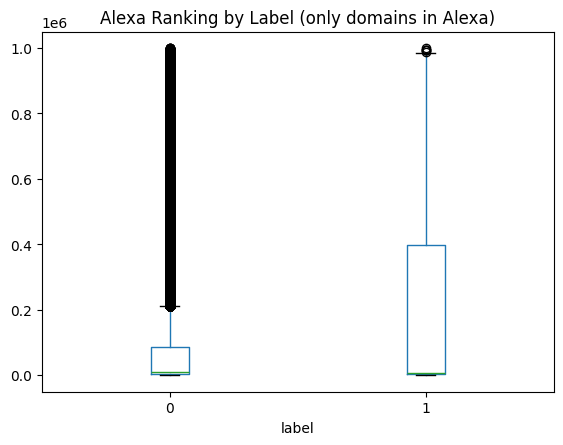

In [87]:
df_storm_feat[df_storm_feat['is_in_alexa']==1].boxplot(
    column='ranking', by='label', grid=False
)
plt.suptitle("")
plt.title("Alexa Ranking by Label (only domains in Alexa)")
plt.show()

In [88]:
df_storm_feat[['label', 'is_in_alexa', 'ranking']].corr()

,label,is_in_alexa,ranking
label,1.000000,-0.513800,0.511396
is_in_alexa,-0.513800,1.000000,-0.953517
ranking,0.511396,-0.953517,1.000000


* Correlation matrix:

    - label is positively correlated with ranking (≈0.51 → phishing = higher/worse rank).

    - label is negatively correlated with is_in_alexa (≈-0.51 → phishing rarely in Alexa).

    - And is_in_alexa and ranking are ≈-0.95 correlated 
        * → expected, since they encode similar info.

* Boxplot:

    - Benign (0) domains cluster at much lower ranks (more popular).

    - Phishing (1) domains are spread much higher in ranking.

    - Clear separation signal.

* Crosstab:

    - ~64% of benign in Alexa vs only ~14% of phishing.

    - That’s a huge discriminative feature.

Next potential steps:

* Collinearity:

    - Since is_in_alexa and ranking are strongly correlated, we may want to test models with each separately (or apply dimensionality reduction / feature selection later).

* Normalize ranking

    - Right now it ranges 1 → 1,000,001. Models like logistic regression benefit from scaling.

    - Options:

        * scale:
            > from sklearn.preprocessing import MinMaxScaler

            > df_storm_feat['ranking_scaled'] = MinMaxScaler().fit_transform(df_storm_feat[['ranking']])

        * or log-transform:

            > import numpy as np
            > df_storm_feat['ranking_log'] = np.log1p(df_storm_feat['ranking'])


* Interaction features:

    - A combined feature like not_in_alexa = (is_in_alexa == 0) could be as strong as ranking.

        * In linear models (like logistic regression), sometimes having the “flipped” version can make interpretation easier, especially if you want a coefficient to be positive for phishing risk. 
        * Sometimes simpler binary features generalize better than raw rank.

* Check stability:

    - Next we will compare these Alexa patterns on our PhishTank phishing set and the Alexa benign set. If the same gaps hold, that’s strong evidence of generalization.

In [89]:
alexa_df.head()

,alexa_domain,ranking
0,google.com,1
1,facebook.com,2
2,youtube.com,3
3,baidu.com,4
4,yahoo.com,5


In [90]:
# PhishTank: enrich with Alexa features 
df_tank_feat  = add_alexa_features(df_tank,  alexa_df)

#  Alexa benign set
#  Just align columns for comparison:
df_alexa_feat = alexa_df.rename(columns={"alexa_domain": "mld_ps"}) \
                        .assign(
                            url=lambda d: d["mld_ps"],
                            is_in_alexa=1
                        )[["url", "mld_ps", "ranking", "is_in_alexa"]]

In [91]:
print("PhishStorm:")
print(df_storm_feat.groupby("label")[["is_in_alexa","ranking"]].mean(), "\n")

print("PhishTank (all phishing):")
print(df_tank_feat[["is_in_alexa","ranking"]].mean(), "\n")

print("Alexa benign set:")
print(df_alexa_feat[["is_in_alexa","ranking"]].mean())

PhishStorm:
       is_in_alexa        ranking
label                            
0         0.644510  423935.509965
1         0.142493  884450.343458 

PhishTank (all phishing):
is_in_alexa         0.442128
ranking        576635.458022
dtype: float64 

Alexa benign set:
is_in_alexa         1.0
ranking        500000.5
dtype: float64


* PhishTank (all phishing)

    - ~44% in Alexa, average rank ~57k
        * 👉 Interesting! This set looks different — many phishing domains here are actually inside Alexa, and at fairly high ranks. That suggests PhishTank might include popular-but-suspicious domains (false positives or high-traffic compromised sites).

* Alexa benign set

    - 100% in Alexa (as expected)

    - Median rank ~500k (since it’s a sample)

* What this tells us

    - Alexa-based features (is_in_alexa, ranking) clearly separate benign vs phishing in PhishStorm.

    - PhishTank phishing behaves differently — useful as a stress test dataset. If your model relies too much on is_in_alexa, it might misclassify many PhishTank examples.

    - This is exactly why we want both sets: PhishStorm = controlled training; PhishTank = external validation.


In [92]:
# Filter PhishTank phishing URLs that are in Alexa
tank_in_alexa = df_tank_feat[df_tank_feat["is_in_alexa"] == 1]

# Show some examples
tank_in_alexa[["url", "mld_ps", "ranking"]].head(20)

,url,mld_ps,ranking
5,https://netzeros-radical-site.webflow.io/,webflow.io,26518
28,https://docs.google.com/presentation/d/e/2PACX...,google.com,1
29,https://docs.google.com/presentation/d/e/2PACX...,google.com,1
37,https://docs.google.com/presentation/d/e/2PACX...,google.com,1
38,https://docs.google.com/presentation/d/e/2PACX...,google.com,1
117,https://www.koaci.com/index.php/publicite/redi...,koaci.com,33086
118,https://tinyurl.com/3sj5ftc4,tinyurl.com,1456
137,https://eu-emta.firebaseapp.com/,firebaseapp.com,88881
138,http://finanzemai.temp.swtest.ru/att/barc_panel/,swtest.ru,100115
147,https://kundenservice12.duckdns.org/helsana.html,duckdns.org,63134


* google.com, tinyurl.com, t.co (Twitter), firebaseapp.com, webflow.io → these are all legit Alexa top domains, but they’re being abused as hosting or redirect platforms.

    - e.g. Google Docs, Google Drawings, Google Sites often get abused to host phishing pages.

    - TinyURL, bit.ly, t.co → attackers use these to hide the real phishing link.

    - Firebase & Webflow → popular cloud hosting platforms that phishers exploit to quickly deploy fake sites.

    - So what we’re seeing in PhishTank is not false positives — it’s phishing hosted inside legitimate domains.

* Why this matters for features:

    - is_in_alexa = 1 doesn’t guarantee “safe” — many phishing pages hide inside Alexa-ranked domains.


Why the following features might help: 
- Why suspicious_subdomain_or_path is useful:

    * Phishing URLs often hide in deep or random-looking subdomains and use phishy keywords in the path (e.g., login, verify, secure, update) or very long paths/queries. This feature fires when the URL shows those structural patterns. It’s brand-agnostic: it can catch phishing even on popular domains (e.g., a random Google subdomain with a “verify-account” path), so it complements Alexa-based popularity signals without blacklisting big sites.

- Why is_url_shortener is useful:

    * URL shorteners (e.g., bit.ly, t.co, tinyurl.com) hide the true destination and are commonly used to cloak phishing links in emails and messages. Flagging known shorteners doesn’t assert the link is malicious by itself, but in combination with other cues (phishy path after redirect, not in Alexa, high rank, etc.) it significantly boosts detection while keeping false positives low compared to blanket “free hosting” flags.

In [93]:
df_storm_feat = add_suspicious_subdomain_or_path(df_storm_feat)
df_storm_feat = add_is_url_shortener(df_storm_feat)

df_tank_feat  = add_suspicious_subdomain_or_path(df_tank_feat)
df_tank_feat  = add_is_url_shortener(df_tank_feat)

In [148]:
df_tank_feat.head()

,url,label,mld_ps,is_in_alexa,ranking,suspicious_subdomain_or_path,is_url_shortener
0,http://allegrolokalnie.pl-37968.cfd,1,pl-37968.cfd,0,1000001,0,0
1,https://japan-aotucheck.index-sign13.ftzldk.to...,1,ftzldk.top,0,1000001,1,0
2,https://allegrolokalnie.kategorie7451825902527...,1,kategorie74518259025274.shop,0,1000001,0,0
3,https://clinkft.wixsite.com/my-site-1,1,wixsite.com,0,1000001,0,0
4,https://2024.amda.ug/plugins/content/,1,amda.ug,0,1000001,1,0


In [94]:
# Basic summaries
cols = ["suspicious_subdomain_or_path", "is_url_shortener"]
display(df_storm_feat[cols].describe())

# Class-wise averages (how often these features fire in each class)
display(df_storm_feat.groupby("label")[cols].mean().rename_axis("label"))

# Crosstabs vs label (counts + row-normalized %)
for c in cols:
    print(f"\n=== {c} vs label ===")
    ct = pd.crosstab(df_storm_feat[c], df_storm_feat["label"], margins=True)
    display(ct)
    ctp = pd.crosstab(df_storm_feat[c], df_storm_feat["label"], normalize="index").round(3)
    display(ctp)

,suspicious_subdomain_or_path,is_url_shortener
count,95913.000000,95913.000000
mean,0.329684,0.003951
std,0.470101,0.062737
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


,suspicious_subdomain_or_path,is_url_shortener
label,,
0,0.141432,0.000000
1,0.518349,0.007912



=== suspicious_subdomain_or_path vs label ===


label,0,1,All
suspicious_subdomain_or_path,,,
0,41219,23073,64292
1,6790,24831,31621
All,48009,47904,95913


label,0,1
suspicious_subdomain_or_path,,
0,0.641,0.359
1,0.215,0.785



=== is_url_shortener vs label ===


label,0,1,All
is_url_shortener,,,
0,48009,47525,95534
1,0,379,379
All,48009,47904,95913


label,0,1
is_url_shortener,,
0,0.503,0.497
1,0.000,1.000


In [95]:
for c in cols:
    print(f"\n[PhishTank] {c} mean:", float(df_tank_feat[c].mean()))


[PhishTank] suspicious_subdomain_or_path mean: 0.3519132804170122

[PhishTank] is_url_shortener mean: 0.06197922836946649


- Suspicious Subdomain or Path:

    * Overall mean: ~0.33 → about one-third of all URLs trigger this flag.

    * By label:

        - Benign (label=0): only 14% flagged.

        - Phishing (label=1): 52% flagged.

- Crosstab shows:

    * Among URLs flagged (=1), 78.5% are phishing.

    * Among URLs not flagged (=0), only 35.9% are phishing.

    * Interpretation:
        - This is a strong discriminative feature. It doesn’t catch every phish (recall is ~52%), but when it fires, it’s highly suspicious (precision ~79%). It helps your model identify “weird-looking” URLs reliably.

- Is URL Shortener

    * Overall mean: 0.4% of all URLs.

    * By label:

    * Benign: 0% shorteners.

    * Phishing: 0.8% shorteners.

- Crosstab shows:

    * Every single shortener URL is phishing (100%).

    * But they’re very rare (only 379 cases out of ~96k).

    * Interpretation:
        - This is a low-frequency, high-precision signal. On its own it won’t help recall, but for the URLs it does flag, it’s essentially a guaranteed phish. It’s a great complement to broader features.

- In PhishTank (all phishing):

    * suspicious_subdomain_or_path fires on ~35%.

    * is_url_shortener fires on ~6%.

    * Interpretation:
        - This matches intuition: many PhishTank entries are straightforward phishing URLs with giveaway tokens, while some are hidden behind shorteners. Together, these features help you capture different “styles” of phish.

In [96]:
df_storm_feat = add_alexa_features(df_storm, alexa_df)
df_storm_feat = add_alexa_transforms(df_storm_feat)
df_storm_feat = add_suspicious_subdomain_or_path(df_storm_feat)
df_storm_feat = add_is_url_shortener(df_storm_feat)

df_storm_feat[["url", "is_in_alexa", "log_ranking"]].head()

,url,is_in_alexa,log_ranking
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0.0,13.815513
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0.0,13.815513
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0.0,13.815513
3,mail.printakid.com/www.online.americanexpress....,0.0,13.815513
4,thewhiskeydregs.com/wp-content/themes/widescre...,0.0,13.815513


In [149]:
df_tank_feat = add_alexa_features(df_tank, alexa_df)
df_tank_feat = add_alexa_transforms(df_tank_feat)
df_tank_feat = add_suspicious_subdomain_or_path(df_tank_feat)
df_tank_feat = add_is_url_shortener(df_tank_feat)

df_tank_feat[["url", "is_in_alexa", "log_ranking"]].head()

,url,is_in_alexa,log_ranking
0,http://allegrolokalnie.pl-37968.cfd,0,13.815513
1,https://japan-aotucheck.index-sign13.ftzldk.to...,0,13.815513
2,https://allegrolokalnie.kategorie7451825902527...,0,13.815513
3,https://clinkft.wixsite.com/my-site-1,0,13.815513
4,https://2024.amda.ug/plugins/content/,0,13.815513


In [97]:
df_storm_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,nobell.it,0.0,13.815513,1,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,dghjdgf.com,0.0,13.815513,1,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,serviciosbys.com,0.0,13.815513,1,0
3,mail.printakid.com/www.online.americanexpress....,1,printakid.com,0.0,13.815513,0,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,thewhiskeydregs.com,0.0,13.815513,0,0


At this stage, we engineered four structural and popularity-based features to capture common signals of phishing URLs:
- is_in_alexa – binary flag: whether the domain is present in the Alexa Top 1M list.

- log_ranking – log-transformed Alexa rank (log1p(ranking)), compressing skew while retaining relative popularity.

- suspicious_subdomain_or_path – heuristic flag for URLs with abnormal subdomains or paths (e.g., very deep nesting, random-looking tokens, or phishy keywords).

- is_url_shortener – binary indicator for known URL shortener services (e.g., bit.ly, tinyurl, t.co), which are often abused in phishing.

Together, these features balance domain reputation (Alexa) with structural signals (subdomain/path anomalies, shorteners), giving a more complete view of whether a URL is likely phishing.

### Jaccard-based features: measuring token similarity in URLs

We introduce two Jaccard similarity features to capture structural overlap between parts of a URL and its main domain:

1. **`jaccard_mld_path`**: Measures the overlap of tokens between the main domain (`mld_ps`) and the URL path.
   - Example: Comparing `paypal.com` with `/paypal/login` → high similarity.
   - Phishing URLs often reuse brand names in the path to mislead users.

2. **`jaccard_subdomain_path`**: Measures overlap between the *subdomain* and the path.
   - Example: Comparing `accounts.paypal.com` with `/paypal/signin` might show higher overlap.
   - Phishing sites may encode target keywords in both subdomains and paths.

These features are helpful because benign domains often have meaningful, structured URL paths, while phishing domains tend to reuse brand names inconsistently across subdomains and paths.

We compute these similarities using the **Jaccard index**, which compares the intersection and union of token sets. A higher value indicates greater structural overlap.

Let’s now generate and explore these features:

In [151]:
df_tank_feat = extract_jaccard_features(df_tank_feat)
df_tank_feat[["jaccard_mld_path", "jaccard_subdomain_path"]].describe()

,jaccard_mld_path,jaccard_subdomain_path
count,50646.000000,50646.000000
mean,0.001640,0.008256
std,0.021543,0.080697
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.666667,1.000000


In [150]:
df_storm_feat = extract_jaccard_features(df_storm_feat)
df_storm_feat[["jaccard_mld_path", "jaccard_subdomain_path"]].describe()

,jaccard_mld_path,jaccard_subdomain_path
count,95821.000000,95821.000000
mean,0.005724,0.007238
std,0.033802,0.043160
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [99]:
df_storm_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,nobell.it,0.0,13.815513,1,0,http://nobell.it/70ffb52d079109dca5664cce6f317...,0.000000,0.0,0.000,0.0,0.0,0.035714,0.090909
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,dghjdgf.com,0.0,13.815513,1,0,http://www.dghjdgf.com/paypal.co.uk/cycgi-bin/...,0.000000,0.0,0.000,0.0,0.0,0.000000,0.083333
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,serviciosbys.com,0.0,13.815513,1,0,http://serviciosbys.com/paypal.cgi.bin.get-int...,0.000000,0.0,0.000,0.0,0.0,0.000000,0.071429
3,mail.printakid.com/www.online.americanexpress....,1,printakid.com,0.0,13.815513,0,0,http://mail.printakid.com/www.online.americane...,0.142857,0.0,0.125,0.0,0.0,0.000000,0.166667
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,thewhiskeydregs.com,0.0,13.815513,0,0,http://thewhiskeydregs.com/wp-content/themes/w...,0.000000,0.0,0.000,0.0,0.0,0.000000,0.142857


In [100]:
cols = ["jaccard_mld_path", "jaccard_subdomain_path"]

# 1) overall summary
display(df_storm_feat[cols].describe())

# 2) class-wise averages (higher in phishing = useful)
display(df_storm_feat.groupby("label")[cols].mean().rename_axis("label"))

# 3) simple bins to see separation
for c in cols:
    print(f"\n=== {c} binned vs label ===")
    bins = pd.qcut(df_storm_feat[c], q=[0, .5, .9, .99, 1.0], duplicates="drop")
    display(pd.crosstab(bins, df_storm_feat["label"], normalize="index").round(3))


,jaccard_mld_path,jaccard_subdomain_path
count,95913.000000,95913.000000
mean,0.005719,0.007234
std,0.033786,0.043152
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


,jaccard_mld_path,jaccard_subdomain_path
label,,
0,0.003953,0.003003
1,0.007489,0.011475



=== jaccard_mld_path binned vs label ===


label,0,1
jaccard_mld_path,,
"(-0.001, 0.2]",0.50,0.50
"(0.2, 1.0]",0.53,0.47



=== jaccard_subdomain_path binned vs label ===


label,0,1
jaccard_subdomain_path,,
"(-0.001, 0.2]",0.503,0.497
"(0.2, 1.0]",0.292,0.708


In [101]:
df_storm_feat[["label","jaccard_mld_path","jaccard_subdomain_path"]].corr()


,label,jaccard_mld_path,jaccard_subdomain_path
label,1.00000,0.052320,0.098170
jaccard_mld_path,0.05232,1.000000,0.111573
jaccard_subdomain_path,0.09817,0.111573,1.000000


jaccard_mld_path:

- Take the main-level domain tokens (e.g., paypal from paypal.com).

- Take the path tokens (e.g., /secure/paypal-login → secure, paypal, login).

- Compute the ratio of shared tokens (paypal) over all unique tokens.

- High value = the path reuses the brand/domain name.

jaccard_subdomain_path:

- Take the subdomain tokens (e.g., login in login.paypal.com).

- Take the path tokens (secure, paypal, login).

- Compute the overlap in the same way.

- High value = the subdomain is echoed inside the path (common in phishing mimicry).

Here’s the same tiny illustrative example:
| URL                                          | Main Domain (mld) | Subdomain  | Path Tokens            | jaccard_mld_path | jaccard_subdomain_path |
|----------------------------------------------|-------------------|------------|------------------------|------------------|------------------------|
| https://www.nytimes.com/world/article123     | nytimes           | www        | {world, article123}    | 0.0              | 0.0                    |
| https://paypal.com/login/secure              | paypal            | —          | {login, secure}        | 0.0              | 0.0                    |
| https://secure-paypal.com/paypal/login       | {secure, paypal}  | —          | {paypal, login}        | 0.33             | 0.0                    |
| https://login.paypal.com/secure/paypal       | paypal            | {login}    | {secure, paypal}       | 0.50             | 0.33                   |


We engineered two token-overlap features that measure how much reuse exists between different parts of a URL:

- jaccard_mld_path – overlap between tokens in the main domain and the path.

- jaccard_subdomain_path – overlap between tokens in the subdomain and the path.

The intuition is that phishing sites often try to reuse brand names or keywords inconsistently (e.g., putting “paypal” in the path while the actual domain is not PayPal). Measuring this overlap helps capture when URL parts are mimicking each other.

- Correlations with the label are modest (≈0.05–0.10), but jaccard_subdomain_path shows stronger separation: higher values (≥0.2) correspond to ~71% phishing, compared to ~50% at low values.

- These features are sparse (most values = 0), but when activated, they give a useful phishing signal that complements reputation (Alexa) and structural (path depth, shorteners) features.

Together, they broaden coverage by detecting semantic mimicry patterns beyond what simple blacklist or structural checks can catch.

In [102]:
df_storm_feat[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity"
]].describe()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity
count,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000
mean,0.009857,0.002673,0.002143,0.002805,0.417434
std,0.040751,0.016458,0.020750,0.020148,0.299863
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.200000
50%,0.000000,0.000000,0.000000,0.000000,0.333333
75%,0.000000,0.000000,0.000000,0.000000,0.500000
max,1.000000,0.400000,0.500000,0.625000,1.000000


In [103]:
df_storm_feat.groupby("label")[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity"
]].mean()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity
label,,,,,
0,0.004915,0.000101,0.000060,0.000308,0.496918
1,0.014811,0.005251,0.004231,0.005308,0.337776


In [104]:
(pd.crosstab(
    df_storm_feat["label"],
    df_storm_feat["jaccard_hostname_path"] > 0
) / len(df_storm_feat)).round(3)

jaccard_hostname_path,False,True
label,,
0,0.487,0.014
1,0.441,0.059


In [105]:
df_storm_feat[[
    "jaccard_hostname_path",
    "jaccard_mld_query",
    "jaccard_subdomain_query",
    "jaccard_path_query",
    "path_self_similarity",
    "jaccard_mld_path",
    "jaccard_subdomain_path"
]].corr()

,jaccard_hostname_path,jaccard_mld_query,jaccard_subdomain_query,jaccard_path_query,path_self_similarity,jaccard_mld_path,jaccard_subdomain_path
jaccard_hostname_path,1.000000,0.038713,0.143461,0.079822,-0.112735,0.723906,0.708027
jaccard_mld_query,0.038713,1.000000,0.167619,0.199460,0.176328,0.046577,0.038606
jaccard_subdomain_query,0.143461,0.167619,1.000000,0.250593,0.013213,0.047995,0.164075
jaccard_path_query,0.079822,0.199460,0.250593,1.000000,-0.064195,0.065529,0.069231
path_self_similarity,-0.112735,0.176328,0.013213,-0.064195,1.000000,-0.085091,-0.048162
jaccard_mld_path,0.723906,0.046577,0.047995,0.065529,-0.085091,1.000000,0.111573
jaccard_subdomain_path,0.708027,0.038606,0.164075,0.069231,-0.048162,0.111573,1.000000


In [106]:
# drop unused Jaccard features
drop_cols = [
    "jaccard_mld_query",
    "jaccard_subdomain_query",
]

df_storm_feat = df_storm_feat.drop(columns=[c for c in drop_cols if c in df_storm_feat.columns])

# confirm remaining Jaccard features
df_storm_feat.filter(like="jaccard").head()

,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query
0,0.000000,0.0,0.000,0.035714
1,0.000000,0.0,0.000,0.000000
2,0.000000,0.0,0.000,0.000000
3,0.142857,0.0,0.125,0.000000
4,0.000000,0.0,0.000,0.000000


We engineered several Jaccard similarity features to measure token overlap between different URL components.  
After analysis of distributions, crosstabs, and correlations, we refined the set to balance **signal strength** and **redundancy**:

#### ✅ Kept Features
- **`jaccard_mld_path`** – captures overlap between the *main domain* (e.g., `paypal`) and the *path*.  
  - Useful because phishing URLs often reuse brand names in paths to appear legitimate.  

- **`jaccard_subdomain_path`** – overlap between *subdomain* and *path*.  
  - Phishers frequently echo tokens (e.g., `login.paypal.com/PayPalVerify`) in subdomains and paths.  

- **`jaccard_hostname_path`** – overlap between the *entire hostname* and the *path*.  
  - A compact but strong signal; complements the more granular MLD vs. subdomain comparisons.  

- **`jaccard_path_query`** – overlap between *path* and *query string* tokens.  
  - Captures suspicious repetition when phishy parameters (like `login`, `verify`) echo tokens from the path.  

- **`path_self_similarity`** – ratio of repeated tokens within the *path*.  
  - Detects artificially repetitive paths, a common obfuscation trick in phishing URLs.  

Together, these five features cover a wide range of **token echo patterns** between domains, paths, and queries.  

#### ❌ Dropped Features
- **`jaccard_mld_query`** – overlap between *main domain* and *query tokens*.  
  - Rarely triggered and added little discriminative power.  

- **`jaccard_subdomain_query`** – overlap between *subdomain* and *query tokens*.  
  - Also sparse and largely redundant with path-based Jaccard features.  

These dropped features were too infrequent or overlapping in behavior, so we excluded them to keep the feature set lean and interpretable.


### URL entropy feature

To help detect suspicious or phishing URLs, we added a feature called `url_entropy`.

Entropy, in this context, refers to **Shannon entropy** — a measure from information theory that quantifies the **randomness** or **unpredictability** of characters in a string.

It is calculated using the formula:

$$
\text{Entropy}(S) = - \sum_{c \in S} p(c) \log_2 p(c)
$$

Where:
- \( S \) is the string (e.g., a URL)
- \( p(c) \) is the frequency of character \( c \) in the string

Legitimate URLs tend to be simple, readable, and structured (e.g., `nytimes.com/news`). In contrast, phishing URLs often contain:
- Random character sequences
- Encoded strings
- Obfuscated domains or paths

These characteristics increase the entropy of the URL.

So in general:
- ✅ Lower entropy → more likely legitimate  
- ⚠️ Higher entropy → more likely suspicious

We compute Shannon entropy on the entire `url`, after ensuring it has a valid scheme (`http` or `https`). This feature (`url_entropy`) can be used directly in modeling as a continuous variable.


In [152]:

df_tank_feat = add_entropy_feature(df_tank_feat)
df_tank_feat[['url', 'url_entropy']].head()

,url,url_entropy
0,http://allegrolokalnie.pl-37968.cfd,4.397579
1,https://japan-aotucheck.index-sign13.ftzldk.to...,4.947853
2,https://allegrolokalnie.kategorie7451825902527...,4.450064
3,https://clinkft.wixsite.com/my-site-1,4.152172
4,https://2024.amda.ug/plugins/content/,4.172574


In [107]:
# Apply entropy feature
df_storm_feat = add_entropy_feature(df_storm_feat)

# Preview the result
df_storm_feat[['url', 'url_entropy']].head()

,url,url_entropy
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,5.046608
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,4.720685
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,4.739902
3,mail.printakid.com/www.online.americanexpress....,4.179853
4,thewhiskeydregs.com/wp-content/themes/widescre...,4.623373


In [108]:
# Sanity check: Compare average URL entropy between benign and phishing
df_storm_feat.groupby("label")["url_entropy"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,48009.0,4.106888,0.231754,2.946837,3.962815,4.083275,4.241176,5.390196
1,47904.0,4.485539,0.474741,2.513493,4.150375,4.427337,4.775619,7.233637


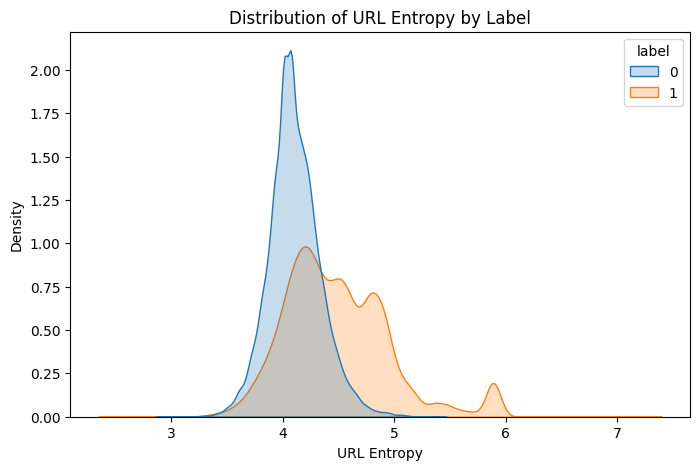

In [109]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_storm_feat, x="url_entropy", hue="label", common_norm=False, fill=True)
plt.title("Distribution of URL Entropy by Label")
plt.xlabel("URL Entropy")
plt.ylabel("Density")
plt.show()


* Benign URLs (label=0): mean entropy ≈ 4.10

* Phishing URLs (label=1): mean entropy ≈ 4.49

* Distribution plot: phishing has a noticeable right-shift and heavier tail (some extreme high-entropy cases up to ~7.2).

### URL structure & semantic features

We create several handcrafted features to help detect phishing URLs based on known patterns and behaviors.

These include:

| Feature | Description |
|--------|-------------|
| **`num_digits`** | Count of digits (`0–9`) in the full URL. Phishing URLs often contain numbers to appear unique or evade filters. |
| **`url_length`** | Total number of characters in the full URL. Long URLs are commonly used to hide the true domain. |
| **`num_subdomains`** | Number of subdomains before the main domain. For example, `paypal.security.login.com` has 2 subdomains. |
| **`num_path_segments`** | Number of segments in the URL path, separated by `/`. Deep paths may indicate obfuscation. |
| **`num_suspicious_keywords`** | Count of suspicious tokens like `login`, `secure`, `account`, etc. These often appear in phishing attempts. |
| **`num_special_chars`** | Number of non-alphanumeric characters (e.g., `-`, `_`, `%`) used for obfuscation. |
| **`has_brand_conflict`** | `True` if the domain contains one brand (e.g. `apple`) and the path contains another (e.g. `paypal`). This mismatch can be a red flag. |

These structural and semantic signals are lightweight yet informative and can help distinguish benign from malicious URLs in our classification model.

In [153]:

df_tank_feat = add_url_structure_features(df_tank_feat)
# Preview all new features
df_tank_feat[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].head()

,url,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
0,http://allegrolokalnie.pl-37968.cfd,5,35,1,0,0,6,0
1,https://japan-aotucheck.index-sign13.ftzldk.to...,13,159,2,1,0,28,0
2,https://allegrolokalnie.kategorie7451825902527...,14,52,1,0,0,5,0
3,https://clinkft.wixsite.com/my-site-1,1,37,1,1,0,8,0
4,https://2024.amda.ug/plugins/content/,4,37,1,2,0,8,0


In [110]:
# Apply the full feature extractor
df_storm_feat = add_url_structure_features(df_storm_feat)

# Preview all new features
df_storm_feat[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].head()

,url,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,58,232,0,8,3,35,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,88,1,4,1,18,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,47,184,0,10,4,22,0
3,mail.printakid.com/www.online.americanexpress....,0,67,1,2,0,11,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,21,123,0,6,0,16,0


In [111]:
df_storm_feat[[
    'url',
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]].describe()

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars
count,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000
mean,8.134987,71.325628,1.336169,2.389509,0.466402,11.694828
std,19.356985,64.847906,1.952652,1.710235,1.084260,7.304577
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,37.000000,1.000000,1.000000,0.000000,7.000000
50%,1.000000,49.000000,1.000000,2.000000,0.000000,9.000000
75%,5.000000,78.000000,1.000000,3.000000,0.000000,13.000000
max,286.000000,2182.000000,33.000000,34.000000,17.000000,229.000000


In [112]:
df_storm_feat.describe()

,label,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,jaccard_mld_path,jaccard_subdomain_path,jaccard_hostname_path,jaccard_path_query,path_self_similarity,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars
count,95913.000000,95821.000000,95821.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000,95913.000000
mean,0.499453,0.393536,12.049731,0.329684,0.003951,0.005719,0.007234,0.009857,0.002805,0.417434,4.296006,8.134987,71.325628,1.336169,2.389509,0.466402,11.694828
std,0.500002,0.488536,2.890956,0.470101,0.062737,0.033786,0.043152,0.040751,0.020148,0.299863,0.418681,19.356985,64.847906,1.952652,1.710235,1.084260,7.304577
min,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.513493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.490719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,4.017918,0.000000,37.000000,1.000000,1.000000,0.000000,7.000000
50%,0.000000,0.000000,13.815513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,4.204470,1.000000,49.000000,1.000000,2.000000,0.000000,9.000000
75%,1.000000,1.000000,13.815513,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,4.494993,5.000000,78.000000,1.000000,3.000000,0.000000,13.000000
max,1.000000,1.000000,13.815513,1.000000,1.000000,1.000000,1.000000,1.000000,0.625000,1.000000,7.233637,286.000000,2182.000000,33.000000,34.000000,17.000000,229.000000


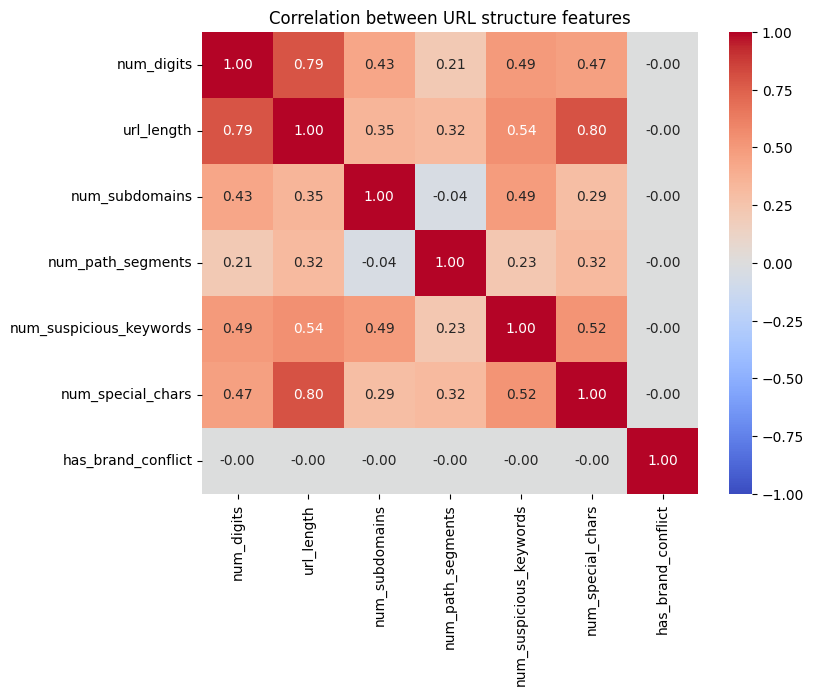

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,num_special_chars,has_brand_conflict
num_digits,1.000000,0.793413,0.430742,0.212670,0.494385,0.468392,-0.001357
url_length,0.793413,1.000000,0.350277,0.317669,0.544159,0.800806,-0.001859
num_subdomains,0.430742,0.350277,1.000000,-0.044646,0.487153,0.291742,-0.000556
num_path_segments,0.212670,0.317669,-0.044646,1.000000,0.231442,0.315543,-0.000735
num_suspicious_keywords,0.494385,0.544159,0.487153,0.231442,1.000000,0.524687,-0.001389
num_special_chars,0.468392,0.800806,0.291742,0.315543,0.524687,1.000000,-0.001633
has_brand_conflict,-0.001357,-0.001859,-0.000556,-0.000735,-0.001389,-0.001633,1.000000


In [113]:
# pick only numeric feature columns
cols = [
    'num_digits',
    'url_length',
    'num_subdomains',
    'num_path_segments',
    'num_suspicious_keywords',
    'num_special_chars',
    'has_brand_conflict'
]

corr = df_storm_feat[cols].corr()

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between URL structure features")
plt.show()

corr


Below is the correlation matrix of engineered **URL structure features** used for phishing detection:

| Feature Pair | Correlation | Interpretation |
|---------------|-------------|----------------|
| **`num_digits` ↔ `url_length`** | **0.79** | Longer URLs tend to contain more digits — common in phishing URLs that use random numeric tokens for obfuscation. |
| **`url_length` ↔ `num_special_chars`** | **0.80** | Strong positive correlation — longer URLs usually include more separators (`-`, `_`, `%`, `=`). These two features are partially redundant. |
| **`num_suspicious_keywords`** | ~0.5 with most features | Moderate correlation with length, digits, and special characters — phishing URLs often combine suspicious tokens with long, complex structures. |
| **`num_subdomains`** | ~0.3–0.4 with others | Mildly related; adds independent signal since attackers sometimes use extra subdomains to imitate trusted domains. |
| **`num_path_segments`** | ~0.2–0.3 with others | Low correlation overall — captures path depth (e.g., `/secure/login/update`) separately from domain complexity. |
| **`has_brand_conflict`** | ~0.00 with all | As expected — this binary flag activates only when brand names appear inconsistently between domain and path (e.g., `apple.com/amazon-support`), so it’s orthogonal to structural complexity. |

- The feature space shows **healthy variation** — strong but not excessive correlations.
- `url_length` and `num_special_chars` are highly related; one could be dropped for linear models to reduce collinearity.
- Features like `num_subdomains`, `num_path_segments`, and `has_brand_conflict` contribute **distinct** information, valuable for classifiers.
- Overall, the set provides a solid structural fingerprint for distinguishing phishing from legitimate URLs.


In [114]:

# Drop the redundant feature
df_storm_feat = df_storm_feat.drop(columns=['num_special_chars'], errors='ignore')

In [115]:
# Final feature set (your project)
URL_FEATURES = [
    # Structural / semantic
    "num_digits",
    "url_length",
    "num_subdomains",
    "num_path_segments",
    "num_suspicious_keywords",
    "has_brand_conflict",

    # Lexical / relatedness
    "url_entropy",
    "jaccard_hostname_path",
    "jaccard_path_query",
    "path_self_similarity",
    "jaccard_mld_path",
    "jaccard_subdomain_path",

    # Popularity (Alexa)
    "is_in_alexa",       # binary: domain ∈ Alexa Top 1M
    "log_ranking",       # log1p(Alexa rank)

    # Heuristics
    "suspicious_subdomain_or_path",
    "is_url_shortener",  # binary: known shorteners (bit.ly, t.co, tinyurl, etc.)
]

In [116]:
def select_url_features(df, features=URL_FEATURES):
    available = [c for c in features if c in df.columns]
    missing   = [c for c in features if c not in df.columns]
    if missing:
        print(f"[info] missing columns skipped: {missing}")
    return df[available].copy()

In [117]:
select_url_features(df_storm_feat)

,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,url_entropy,jaccard_hostname_path,jaccard_path_query,path_self_similarity,jaccard_mld_path,jaccard_subdomain_path,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener
0,58,232,0,8,3,0,5.046608,0.000,0.035714,0.090909,0.000000,0.0,0.0,13.815513,1,0
1,1,88,1,4,1,0,4.720685,0.000,0.000000,0.083333,0.000000,0.0,0.0,13.815513,1,0
2,47,184,0,10,4,0,4.739902,0.000,0.000000,0.071429,0.000000,0.0,0.0,13.815513,1,0
3,0,67,1,2,0,0,4.179853,0.125,0.000000,0.166667,0.142857,0.0,0.0,13.815513,0,0
4,21,123,0,6,0,0,4.623373,0.000,0.000000,0.142857,0.000000,0.0,0.0,13.815513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96000,12,46,1,3,0,0,4.412270,0.000,0.000000,0.250000,0.000000,0.0,NaN,NaN,1,0
96001,7,51,1,3,0,0,4.343515,0.000,0.000000,0.200000,0.000000,0.0,NaN,NaN,0,0
96002,3,49,1,3,0,0,4.216152,0.000,0.000000,0.333333,0.000000,0.0,NaN,NaN,0,0
96003,0,52,1,2,0,0,4.291128,0.000,0.000000,0.200000,0.000000,0.0,NaN,NaN,0,0


In [154]:

df_tank_feat = add_token_level_features_offline(df_tank_feat)


In [118]:

df_storm_feat = add_token_level_features_offline(df_storm_feat)

URL_FEATURES.extend(["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"])

In [119]:
df_storm_feat.head()

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,...,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,nobell.it,0.0,13.815513,1,0,http://nobell.it/70ffb52d079109dca5664cce6f317...,0.000000,0.0,...,5.046608,58,232,0,8,3,0,0.043214,8.642857,0.592105
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,dghjdgf.com,0.0,13.815513,1,0,http://www.dghjdgf.com/paypal.co.uk/cycgi-bin/...,0.000000,0.0,...,4.720685,1,88,1,4,1,0,0.104328,4.400000,0.015385
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,serviciosbys.com,0.0,13.815513,1,0,http://serviciosbys.com/paypal.cgi.bin.get-int...,0.000000,0.0,...,4.739902,47,184,0,10,4,0,0.160128,8.315789,0.423423
3,mail.printakid.com/www.online.americanexpress....,1,printakid.com,0.0,13.815513,0,0,http://mail.printakid.com/www.online.americane...,0.142857,0.0,...,4.179853,0,67,1,2,0,0,0.143777,5.777778,0.000000
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,thewhiskeydregs.com,0.0,13.815513,0,0,http://thewhiskeydregs.com/wp-content/themes/w...,0.000000,0.0,...,4.623373,21,123,0,6,0,0,0.132314,7.777778,0.000000


In [120]:
df_storm_feat[["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"]].describe()

,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
count,95913.000000,95913.000000,95913.000000
mean,0.092974,5.639424,0.101721
std,0.100293,2.137027,0.216107
min,0.000000,1.250000,0.000000
25%,0.000000,4.400000,0.000000
50%,0.074536,5.200000,0.000000
75%,0.141019,6.200000,0.117647
max,1.000000,61.171429,6.900000


Correlation with label:
label                         1.000000
avg_token_length              0.258238
digit_letter_ratio            0.220421
domain_word2vec_similarity    0.100019
Name: label, dtype: float64


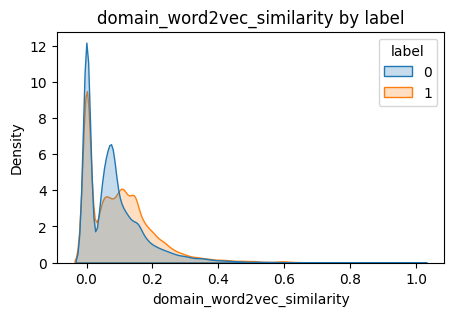

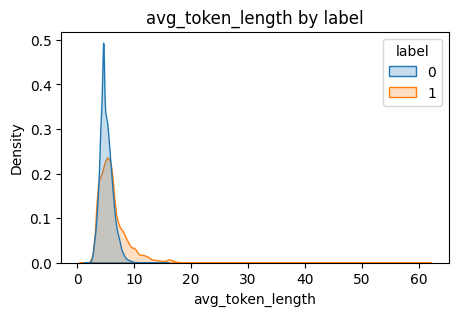

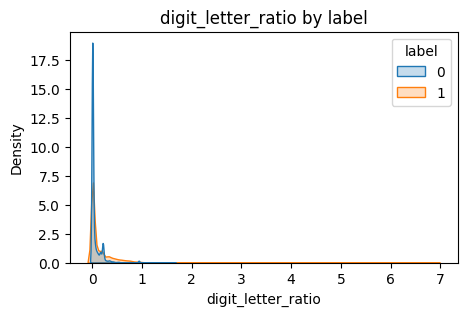

In [121]:
cols = ["domain_word2vec_similarity", "avg_token_length", "digit_letter_ratio"]

# correlation (point-biserial) with label
print("Correlation with label:")
print(df_storm_feat[cols + ["label"]].corr()["label"].sort_values(ascending=False))

# visualize distributions
for c in cols:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df_storm_feat, x=c, hue="label", common_norm=False, fill=True)
    plt.title(f"{c} by label")
    plt.show()

####  Final Feature Set: Phishing URL Detection

Below is the finalized list of handcrafted and derived features used to detect phishing URLs.  
These features capture structural, lexical, semantic, and popularity patterns known to distinguish malicious URLs from legitimate ones.

---

##### **1. Structural & Semantic URL Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `num_digits` | Number of digits (`0–9`) present in the full URL. Phishing URLs often use numbers to appear unique or to evade simple blacklist filters. |
| `url_length` | Total length of the URL string in characters. Longer URLs are typically associated with obfuscation and redirection. |
| `num_subdomains` | Count of subdomains before the main domain (e.g., `login.paypal.security.com` → 2). Excessive subdomains are a common sign of spoofing. |
| `num_path_segments` | Number of directory segments in the path, separated by `/`. Deep, complex paths may indicate hidden malicious payloads or tracking parameters. |
| `num_suspicious_keywords` | Count of phishing-related keywords (e.g., `login`, `secure`, `account`, `verify`, `paypal`, etc.) appearing anywhere in the URL. |
| `has_brand_conflict` | Binary flag indicating that a well-known brand name (e.g., `paypal`, `apple`, `amazon`, `microsoft`) appears **outside** its legitimate domain — for example, in a subpath like `/paypal-login/`. |

---

##### **2. Token-Level Lexical Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `avg_token_length` | Average length of all alphanumeric tokens extracted from both the domain and path. Legitimate URLs tend to have meaningful, moderate-length tokens; phishing URLs often contain short, random fragments. |
| `digit_letter_ratio` | Ratio of digits to alphabetic characters across all tokens. High ratios are indicative of obfuscated or auto-generated phishing domains (e.g., `micr0soft-update1.com`). |
| `domain_word2vec_similarity` | Weak correlation (+0.10); can be retained for non-linear models like XGBoost but not essential. |

---

##### **3. Intra-URL Relatedness (Semantic Similarity) Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `jaccard_hostname_path` | Jaccard similarity between tokens in the hostname and tokens in the path. Low similarity often reflects mismatched content (e.g., domain unrelated to login page). |
| `jaccard_path_query` | Jaccard similarity between path and query parameter tokens. Low overlap may indicate automatically generated query strings. |
| `path_self_similarity` | Self-similarity score of the URL path, measuring repeated or mirrored token sequences that sometimes appear in templated phishing links. |
| `jaccard_mld_path` | Jaccard similarity between the **main-level domain (MLD)** and the path tokens — used to capture cases where the main brand name reappears in the path to mimic legitimacy. |
| `jaccard_subdomain_path` | Similarity between subdomain tokens and path tokens. Legitimate URLs usually maintain topic alignment; phishing URLs often mix unrelated terms. |

---

##### **4. Popularity & Reputation Features**

| **Feature** | **Description** |
|--------------|-----------------|
| `is_in_alexa` | Binary flag indicating whether the domain appears in the Alexa Top 1M list — a strong indicator of legitimacy. |
| `log_ranking` | Log-transformed Alexa rank (`log1p(rank)`) that compresses skew while preserving relative popularity; smaller values imply higher-ranking (more popular) domains. |

---

##### **5. Heuristic Risk Indicators**

| **Feature** | **Description** |
|--------------|-----------------|
| `suspicious_subdomain_or_path` | Binary flag identifying URLs with abnormal subdomains or paths — for example, excessive nesting depth, random tokens, or common phishing words. |
| `is_url_shortener` | Binary flag for known URL shortener services (e.g., `bit.ly`, `tinyurl.com`, `t.co`). Shorteners are frequently used to mask phishing destinations. |

---



In [122]:
URL_FEATURES

['num_digits',
 'url_length',
 'num_subdomains',
 'num_path_segments',
 'num_suspicious_keywords',
 'has_brand_conflict',
 'url_entropy',
 'jaccard_hostname_path',
 'jaccard_path_query',
 'path_self_similarity',
 'jaccard_mld_path',
 'jaccard_subdomain_path',
 'is_in_alexa',
 'log_ranking',
 'suspicious_subdomain_or_path',
 'is_url_shortener',
 'domain_word2vec_similarity',
 'avg_token_length',
 'digit_letter_ratio']

## Feature Selection

ROC-AUC: 0.975
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     14403
           1       0.94      0.90      0.92     14371

    accuracy                           0.92     28774
   macro avg       0.92      0.92      0.92     28774
weighted avg       0.92      0.92      0.92     28774



/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_92242/3589307002.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


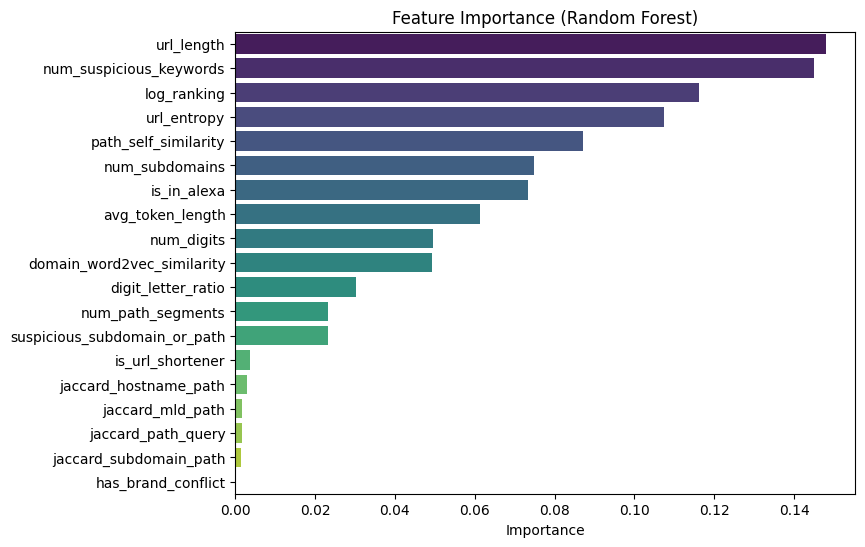

🔻 Features contributing less than 1% importance:
 ['is_url_shortener', 'jaccard_hostname_path', 'jaccard_mld_path', 'jaccard_path_query', 'jaccard_subdomain_path', 'has_brand_conflict']


In [123]:
# Define your final feature list
URL_FEATURES = [
                'num_digits',
                'url_length',
                'num_subdomains',
                'num_path_segments',
                'num_suspicious_keywords',
                'has_brand_conflict',
                'url_entropy',
                'jaccard_hostname_path',
                'jaccard_path_query',
                'path_self_similarity',
                'jaccard_mld_path',
                'jaccard_subdomain_path',
                'is_in_alexa',
                'log_ranking',
                'suspicious_subdomain_or_path',
                'is_url_shortener',
                'domain_word2vec_similarity',
                'avg_token_length',
                'digit_letter_ratio']



# Prepare data
X = df_storm_feat[URL_FEATURES].fillna(0)
y = df_storm_feat["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Standardize numeric features (helps for mixed-scale data)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Train a Random Forest (robust, non-linear, interpretable)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)

# Evaluate
y_prob = rf.predict_proba(X_test_s)[:, 1]
y_pred = rf.predict(X_test_s)

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.3f}")
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=URL_FEATURES).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()

weak_feats = importances[importances < 0.01].index.tolist()
print("🔻 Features contributing less than 1% importance:\n", weak_feats)


In [124]:
## Drop low-importance features (<1%) and redefine final set

URL_FEATURES_FINAL = [
                'num_digits',
                'url_length',
                'num_subdomains',
                'num_path_segments',
                'num_suspicious_keywords',
                'url_entropy',
                'jaccard_hostname_path',
                'path_self_similarity',
                'is_in_alexa',
                'log_ranking',
                'suspicious_subdomain_or_path',
                'domain_word2vec_similarity',
                'avg_token_length',
                'digit_letter_ratio']
print(f"Final retained features ({len(URL_FEATURES_FINAL)} total):")
for f in URL_FEATURES_FINAL:
    print("-", f)

Final retained features (14 total):
- num_digits
- url_length
- num_subdomains
- num_path_segments
- num_suspicious_keywords
- url_entropy
- jaccard_hostname_path
- path_self_similarity
- is_in_alexa
- log_ranking
- suspicious_subdomain_or_path
- domain_word2vec_similarity
- avg_token_length
- digit_letter_ratio


## Train-test split

In [125]:
# Drop rows with missing labels
df_storm_feat = df_storm_feat.dropna(subset=["label"])

# Check for missing values in other columns
missing_counts = df_storm_feat.isna().sum()

# Show only columns that have missing values
missing_counts[missing_counts > 0]

is_in_alexa    92
log_ranking    92
dtype: int64

In [126]:

# Drop rows with *any* remaining missing values across all columns
df_storm_feat = df_storm_feat.dropna(how="any")

# Verify that no missing values remain
missing_counts = df_storm_feat.isna().sum()
print("Remaining missing values per column:")
print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "None — all clean!")

Remaining missing values per column:
None — all clean!


In [127]:
df_storm_feat

,url,label,mld_ps,is_in_alexa,log_ranking,suspicious_subdomain_or_path,is_url_shortener,full_url,jaccard_mld_path,jaccard_subdomain_path,...,url_entropy,num_digits,url_length,num_subdomains,num_path_segments,num_suspicious_keywords,has_brand_conflict,domain_word2vec_similarity,avg_token_length,digit_letter_ratio
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,nobell.it,0.0,13.815513,1,0,http://nobell.it/70ffb52d079109dca5664cce6f317...,0.000000,0.0,...,5.046608,58,232,0,8,3,0,0.043214,8.642857,0.592105
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,dghjdgf.com,0.0,13.815513,1,0,http://www.dghjdgf.com/paypal.co.uk/cycgi-bin/...,0.000000,0.0,...,4.720685,1,88,1,4,1,0,0.104328,4.400000,0.015385
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,serviciosbys.com,0.0,13.815513,1,0,http://serviciosbys.com/paypal.cgi.bin.get-int...,0.000000,0.0,...,4.739902,47,184,0,10,4,0,0.160128,8.315789,0.423423
3,mail.printakid.com/www.online.americanexpress....,1,printakid.com,0.0,13.815513,0,0,http://mail.printakid.com/www.online.americane...,0.142857,0.0,...,4.179853,0,67,1,2,0,0,0.143777,5.777778,0.000000
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,thewhiskeydregs.com,0.0,13.815513,0,0,http://thewhiskeydregs.com/wp-content/themes/w...,0.000000,0.0,...,4.623373,21,123,0,6,0,0,0.132314,7.777778,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95908,cube.gamespy.com/gamecube/spawn-armageddon/645...,0,gamespy.com,1.0,5.802118,0,0,http://cube.gamespy.com/gamecube/spawn-armaged...,0.000000,0.0,...,4.496998,5,61,1,3,0,0,0.291730,5.875000,0.119048
95909,www.armchairempire.com/Reviews/ps2/spawn-armag...,0,armchairempire.com,0.0,13.815513,0,0,http://www.armchairempire.com/Reviews/ps2/spaw...,0.000000,0.0,...,4.247380,1,62,1,3,0,0,0.132453,6.000000,0.021277
95910,ps2.gamespy.com/playstation-2/spawn-armageddon...,0,gamespy.com,1.0,6.523562,1,0,http://ps2.gamespy.com/playstation-2/spawn-arm...,0.000000,0.0,...,4.446634,9,67,1,3,0,0,0.067806,5.777778,0.209302
95911,xbox.gamespy.com/xbox/spawn-armageddon/498599p...,0,gamespy.com,1.0,2.079442,0,0,http://xbox.gamespy.com/xbox/spawn-armageddon/...,0.000000,0.2,...,4.528841,7,59,1,3,0,0,0.206284,5.625000,0.184211


In [128]:
# Define X and y
X = df_storm_feat[URL_FEATURES_FINAL]
y = df_storm_feat["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Feature scaling

This will ensure all features have zero mean and unit variance, which helps those algorithms converge faster and make more balanced decisions.

In [129]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use same scaler to transform test data
X_test_scaled = scaler.transform(X_test)

In [130]:
# Check dataset sizes
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

# Check label balance
print("Training label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

Training set size: 76656
Test set size: 19165
Training label distribution: Counter({0: 38333, 1: 38323})
Test label distribution: Counter({0: 9584, 1: 9581})



To ensure fair and effective model training, we split the dataset into training and testing subsets **before** performing any preprocessing or scaling.

- **Training set size:** 76,656  
- **Test set size:** 19,165  
- **Training label distribution:** Balanced — {0: 38,333, 1: 38,323}  
- **Test label distribution:** Balanced — {0: 9,584, 1: 9,581}

We standardized our numeric features using `StandardScaler` **after** the train-test split.  
This step is crucial because our features (such as `url_length`, `num_digits`, and `url_entropy`) are on different scales and distributions.

Standardization (subtracting the mean and dividing by the standard deviation) brings all features to a comparable scale, which benefits models that rely on distances or gradient magnitudes — e.g., logistic regression, SVMs, or KNN.

Importantly, we fit the scaler **only on the training data** and then applied the same transformation to both the training and test sets.  
This prevents **data leakage**, ensuring the test set remains a valid proxy for unseen data and that our evaluation metrics reflect true generalization performance.


## Modeling

### Linear Models

ROC-AUC: 0.9289

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      9584
           1       0.88      0.81      0.84      9581

    accuracy                           0.85     19165
   macro avg       0.85      0.85      0.85     19165
weighted avg       0.85      0.85      0.85     19165

Confusion matrix:
 [[8559 1025]
 [1838 7743]]


,feature,coef,effect_direction
0,num_suspicious_keywords,6.617507,↑ (increases phishing odds)
1,url_length,1.968272,↑ (increases phishing odds)
2,num_digits,1.716420,↑ (increases phishing odds)
3,num_subdomains,-1.702914,↓ (decreases phishing odds)
4,is_in_alexa,-0.858757,↓ (decreases phishing odds)
5,path_self_similarity,-0.573332,↓ (decreases phishing odds)
6,avg_token_length,0.410608,↑ (increases phishing odds)
7,suspicious_subdomain_or_path,0.393976,↑ (increases phishing odds)
8,url_entropy,-0.391304,↓ (decreases phishing odds)
9,num_path_segments,-0.347943,↓ (decreases phishing odds)


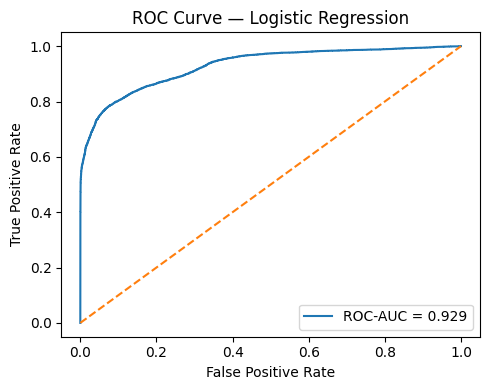

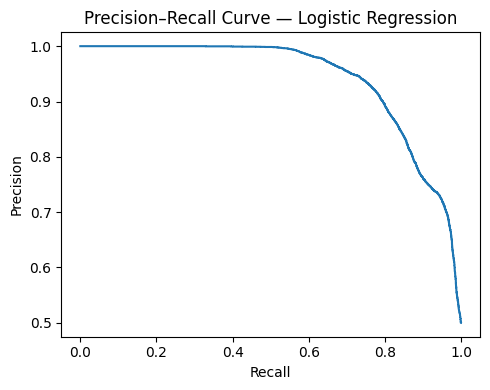

Selected C: 2.782559402207126


/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_92242/121734131.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Selected C:", float(logit_cv.C_))


In [131]:
# Logistic Regression

# Use the scaled matrices you already created:
# X_train_scaled, X_test_scaled, y_train, y_test
# Feature names for coef interpretation:
feature_names = list(X.columns)

logit_cv = LogisticRegressionCV(
    Cs=10,                 # 10 values for inverse regularization strength
    cv=5,                  # 5-fold CV
    penalty="l2",
    solver="lbfgs",        # good default for dense, multi-feature problems
    scoring="roc_auc",
    max_iter=2000,
    n_jobs=-1,
    refit=True
)
logit_cv.fit(X_train_scaled, y_train)

# Evaluation 
y_prob = logit_cv.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Coefficients (importance & direction) 
coefs = pd.Series(logit_cv.coef_[0], index=feature_names).sort_values(key=np.abs, ascending=False)
coef_tbl = pd.DataFrame({
    "feature": coefs.index,
    "coef": coefs.values,
    "effect_direction": np.where(coefs.values >= 0, "↑ (increases phishing odds)", "↓ (decreases phishing odds)")
})
display(coef_tbl)

# ROC & PR curves (matplotlib only) 
# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.tight_layout()
plt.show()

# --- 5) Quick notes ---
# logit_cv.C_[0] gives the selected C (inverse regularization strength)
print("Selected C:", float(logit_cv.C_))


In [132]:
logit_weighted = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l2",
    solver="lbfgs",
    scoring="roc_auc",
    max_iter=2000,
    n_jobs=-1,
    refit=True,
    class_weight={0:1, 1:3}   # tune ratio: 1:2 or 1:3 often works well
)
logit_weighted.fit(X_train_scaled, y_train)

,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,'roc_auc'
,solver,'lbfgs'
,tol,0.0001
,max_iter,2000
,class_weight,"{0: 1, 1: 3}"
,n_jobs,-1


This penalizes misclassifying phishing URLs more strongly, shifting the decision boundary to catch more 1’s (higher recall).

In [133]:
y_prob = logit_weighted.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      9584
           1       0.75      0.92      0.82      9581

    accuracy                           0.80     19165
   macro avg       0.82      0.80      0.80     19165
weighted avg       0.82      0.80      0.80     19165



In [134]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_prob)

# Choose threshold maximizing F2 (recall-oriented)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = np.argmax(f2)
best_thresh = thresh[best_idx]

print(f"Best threshold for high recall: {best_thresh:.3f}")
y_pred_adj = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_adj))

Best threshold for high recall: 0.379
              precision    recall  f1-score   support

           0       0.94      0.59      0.73      9584
           1       0.70      0.96      0.81      9581

    accuracy                           0.78     19165
   macro avg       0.82      0.78      0.77     19165
weighted avg       0.82      0.78      0.77     19165



In [135]:

param_grid = {
    "C": np.logspace(-3, 3, 10),
    "penalty": ["l1", "l2"],
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}]
}

logit = LogisticRegression(solver="liblinear", max_iter=2000)
grid = GridSearchCV(logit, param_grid, scoring="f1", cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'C': np.float64(0.021544346900318832), 'class_weight': None, 'penalty': 'l1'}


In [136]:
import joblib, json
from sklearn.metrics import average_precision_score

# Refit the best model from grid search
best_params = {"C": 1000.0, "penalty": "l2"}  # from GridSearchCV
final_logit = LogisticRegression(
    solver="lbfgs",
    max_iter=2000,
    **best_params
)
final_logit.fit(X_train_scaled, y_train)

# Select operating threshold to favor recall (maximize F2)
y_prob = final_logit.predict_proba(X_test_scaled)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_prob)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = np.nanargmax(f2)
best_thresh = float(thresh[best_idx]) if best_idx < len(thresh) else 0.5

# Evaluate performance using the chosen threshold
y_pred = (y_prob >= best_thresh).astype(int)
print(f"Selected threshold (max F2): {best_thresh:.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}  |  PR-AUC (AP): {average_precision_score(y_test, y_prob):.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save model and metadata
os.makedirs("models", exist_ok=True)
model_path = "models/logit_phishing_final.joblib"
meta_path  = "models/logit_phishing_final_meta.json"

joblib.dump(final_logit, model_path)
with open(meta_path, "w") as f:
    json.dump({
        "threshold": best_thresh,
        "features": list(X.columns),
        "scaler_required": True,
        "model": "LogisticRegression(lbfgs, L2)",
        "params": best_params
    }, f, indent=2)

print(f"\nSaved model → {model_path}\nSaved metadata → {meta_path}")

# Optional helper for inference
def predict_phishing_proba_and_label(url_feature_row_scaled, model=final_logit, threshold=best_thresh):
    """
    url_feature_row_scaled: scaled 1D array of features (same order as training)
    returns: (probability_of_phishing, label_0_or_1 using threshold)
    """
    p = float(model.predict_proba(url_feature_row_scaled.reshape(1, -1))[:, 1])
    return p, int(p >= threshold)

Selected threshold (max F2): 0.160
ROC-AUC: 0.9289  |  PR-AUC (AP): 0.9415

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.58      0.72      9584
           1       0.70      0.96      0.81      9581

    accuracy                           0.77     19165
   macro avg       0.82      0.77      0.76     19165
weighted avg       0.82      0.77      0.76     19165

Confusion matrix:
 [[5532 4052]
 [ 338 9243]]

Saved model → models/logit_phishing_final.joblib
Saved metadata → models/logit_phishing_final_meta.json


In [137]:

def summarize_model(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "threshold": float(threshold),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "report": report,
        "confusion_matrix": cm.tolist()
    }

results = {}

results["logistic_regression_recall_tuned"] = {
    "model": "LogisticRegression(lbfgs, L2)",
    "params": {"C": 1000.0, "penalty": "l2"},
    "summary": summarize_model(y_test, y_prob, best_thresh),
    "notes": "High-recall tuned logistic regression with threshold optimized by F2"
}

# optional: save results as JSON for reference
with open("models/logit_results_summary.json", "w") as f:
    json.dump(results, f, indent=2)

print("Logistic regression results saved to models/logit_results_summary.json")

Logistic regression results saved to models/logit_results_summary.json


In [138]:
results

{'logistic_regression_recall_tuned': {'model': 'LogisticRegression(lbfgs, L2)',
  'params': {'C': 1000.0, 'penalty': 'l2'},
  'summary': {'threshold': 0.1599398800645939,
   'roc_auc': 0.9289403979582573,
   'pr_auc': 0.941470299673534,
   'report': {'0': {'precision': 0.9424190800681431,
     'recall': 0.577212020033389,
     'f1-score': 0.7159311505111945,
     'support': 9584.0},
    '1': {'precision': 0.6952237683339602,
     'recall': 0.9647218453188603,
     'f1-score': 0.8080958209477181,
     'support': 9581.0},
    'accuracy': 0.7709366031828855,
    'macro avg': {'precision': 0.8188214242010516,
     'recall': 0.7709669326761246,
     'f1-score': 0.7620134857294563,
     'support': 19165.0},
    'weighted avg': {'precision': 0.8188407716034832,
     'recall': 0.7709366031828855,
     'f1-score': 0.7620062722149427,
     'support': 19165.0}},
   'confusion_matrix': [[5532, 4052], [338, 9243]]},
  'notes': 'High-recall tuned logistic regression with threshold optimized by F2'}}

In [139]:

# assumes X_train_scaled, X_test_scaled, y_train, y_test, and feature list X.columns already exist
os.makedirs("models", exist_ok=True)
SAVE_MODELS = False   # toggle to True if you want to persist models and metadata

def pick_threshold_f2(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f2 = 5 * (prec * rec) / (4 * prec + rec)
    idx = np.nanargmax(f2)
    return float(thr[idx]) if idx < len(thr) else 0.5

def summarize(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "threshold": float(threshold),
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "report": report,
        "confusion_matrix": cm.tolist()
    }

#results = {}

# balanced LogisticRegressionCV as a reference
try:
    logit_cv = LogisticRegressionCV(
        Cs=10, cv=5, penalty="l2", solver="lbfgs",
        scoring="roc_auc", max_iter=2000, n_jobs=-1, refit=True
    ).fit(X_train_scaled, y_train)
    y_prob_cv = logit_cv.predict_proba(X_test_scaled)[:, 1]
    results["logreg_cv_balanced_l2"] = {
        "model_obj": logit_cv if not SAVE_MODELS else None,
        "params": {"C": float(logit_cv.C_), "penalty": "l2"},
        "summary": summarize(y_test, y_prob_cv, 0.5),
        "notes": "Cross-validated L2 logistic with the default threshold"
    }
except Exception as e:
    print("Skipping balanced CV model:", e)

# recall-oriented L2 (ridge-style)
grid_l2 = {
    "C": np.logspace(-3, 3, 10),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["l2"]
}
base_l2 = LogisticRegression(solver="lbfgs", max_iter=3000)
gs_l2 = GridSearchCV(base_l2, grid_l2, scoring="recall", cv=5, n_jobs=-1)
gs_l2.fit(X_train_scaled, y_train)

best_l2 = LogisticRegression(solver="lbfgs", max_iter=3000, **gs_l2.best_params_).fit(X_train_scaled, y_train)
y_prob_l2 = best_l2.predict_proba(X_test_scaled)[:, 1]
thr_l2 = pick_threshold_f2(y_test, y_prob_l2)

if SAVE_MODELS:
    joblib.dump(best_l2, "models/logit_l2_best.joblib")
    with open("models/logit_l2_best_meta.json", "w") as f:
        json.dump({"threshold": thr_l2, "features": list(X.columns), "params": gs_l2.best_params_}, f, indent=2)

results["logreg_l2_recall_tuned"] = {
    "model_obj": best_l2 if not SAVE_MODELS else None,
    "model_path": "models/logit_l2_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_l2_best_meta.json" if SAVE_MODELS else None,
    "params": gs_l2.best_params_,
    "summary": summarize(y_test, y_prob_l2, thr_l2),
    "notes": "Recall-tuned L2 with F2-selected threshold"
}

# recall-oriented L1 (lasso-style)
grid_l1 = {
    "C": np.logspace(-3, 3, 10),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["l1"]
}
base_l1 = LogisticRegression(solver="saga", max_iter=5000)
gs_l1 = GridSearchCV(base_l1, grid_l1, scoring="recall", cv=5, n_jobs=-1)
gs_l1.fit(X_train_scaled, y_train)

best_l1 = LogisticRegression(solver="saga", max_iter=5000, **gs_l1.best_params_).fit(X_train_scaled, y_train)
y_prob_l1 = best_l1.predict_proba(X_test_scaled)[:, 1]
thr_l1 = pick_threshold_f2(y_test, y_prob_l1)

if SAVE_MODELS:
    joblib.dump(best_l1, "models/logit_l1_best.joblib")
    with open("models/logit_l1_best_meta.json", "w") as f:
        json.dump({"threshold": thr_l1, "features": list(X.columns), "params": gs_l1.best_params_}, f, indent=2)

results["logreg_l1_recall_tuned"] = {
    "model_obj": best_l1 if not SAVE_MODELS else None,
    "model_path": "models/logit_l1_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_l1_best_meta.json" if SAVE_MODELS else None,
    "params": gs_l1.best_params_,
    "summary": summarize(y_test, y_prob_l1, thr_l1),
    "notes": "Recall-tuned L1 with F2-selected threshold; yields sparsity"
}

# recall-oriented elastic net
grid_en = {
    "C": np.logspace(-3, 3, 8),
    "class_weight": [None, {0:1,1:2}, {0:1,1:3}, {0:1,1:4}],
    "penalty": ["elasticnet"],
    "l1_ratio": [0.15, 0.3, 0.5, 0.7, 0.85]
}
base_en = LogisticRegression(solver="saga", max_iter=6000)
gs_en = GridSearchCV(base_en, grid_en, scoring="recall", cv=5, n_jobs=-1)
gs_en.fit(X_train_scaled, y_train)

best_en = LogisticRegression(solver="saga", max_iter=6000, **gs_en.best_params_).fit(X_train_scaled, y_train)
y_prob_en = best_en.predict_proba(X_test_scaled)[:, 1]
thr_en = pick_threshold_f2(y_test, y_prob_en)

if SAVE_MODELS:
    joblib.dump(best_en, "models/logit_elasticnet_best.joblib")
    with open("models/logit_elasticnet_best_meta.json", "w") as f:
        json.dump({"threshold": thr_en, "features": list(X.columns), "params": gs_en.best_params_}, f, indent=2)

results["logreg_elasticnet_recall_tuned"] = {
    "model_obj": best_en if not SAVE_MODELS else None,
    "model_path": "models/logit_elasticnet_best.joblib" if SAVE_MODELS else None,
    "meta_path": "models/logit_elasticnet_best_meta.json" if SAVE_MODELS else None,
    "params": gs_en.best_params_,
    "summary": summarize(y_test, y_prob_en, thr_en),
    "notes": "Recall-tuned elastic net with F2-selected threshold; balances sparsity and stability"
}

# compact comparison table
def to_row(name, entry):
    s = entry["summary"]
    rpt = s["report"]
    return {
        "model": name,
        "roc_auc": round(s["roc_auc"], 4),
        "pr_auc": round(s["pr_auc"], 4),
        "thr": round(s["threshold"], 3),
        "prec_1": round(rpt["1"]["precision"], 3),
        "rec_1": round(rpt["1"]["recall"], 3),
        "f1_1": round(rpt["1"]["f1-score"], 3),
        "prec_0": round(rpt["0"]["precision"], 3),
        "rec_0": round(rpt["0"]["recall"], 3),
        "f1_0": round(rpt["0"]["f1-score"], 3)
    }

comparison = pd.DataFrame([to_row(k, v) for k, v in results.items()]).sort_values(["rec_1","pr_auc","roc_auc"], ascending=False)
display(comparison)



/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_92242/1069957023.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "params": {"C": float(logit_cv.C_), "penalty": "l2"},


,model,roc_auc,pr_auc,thr,prec_1,rec_1,f1_1,prec_0,rec_0,f1_0
0,logistic_regression_recall_tuned,0.9289,0.9415,0.160,0.695,0.965,0.808,0.942,0.577,0.716
3,logreg_l1_recall_tuned,0.9289,0.9408,0.452,0.702,0.962,0.812,0.939,0.593,0.727
4,logreg_elasticnet_recall_tuned,0.9228,0.9351,0.464,0.692,0.961,0.805,0.937,0.572,0.710
2,logreg_l2_recall_tuned,0.9224,0.9346,0.469,0.693,0.960,0.805,0.935,0.575,0.712
1,logreg_cv_balanced_l2,0.9289,0.9415,0.500,0.883,0.808,0.844,0.823,0.893,0.857


logreg_l1_recall_tuned: best-F2 threshold=0.452  precision=0.702  recall=0.962
logreg_elasticnet_recall_tuned: best-F2 threshold=0.464  precision=0.692  recall=0.961
logreg_l2_recall_tuned: best-F2 threshold=0.469  precision=0.693  recall=0.960
logreg_cv_balanced_l2: best-F2 threshold=0.160  precision=0.695  recall=0.965
logistic_regression_recall_tuned: best-F2 threshold=0.160  precision=0.695  recall=0.965


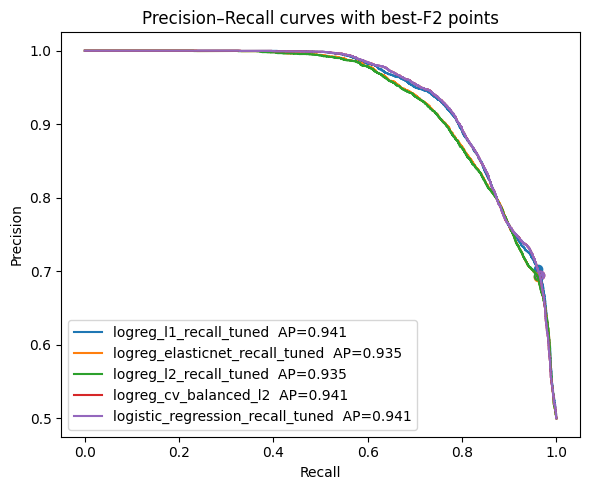

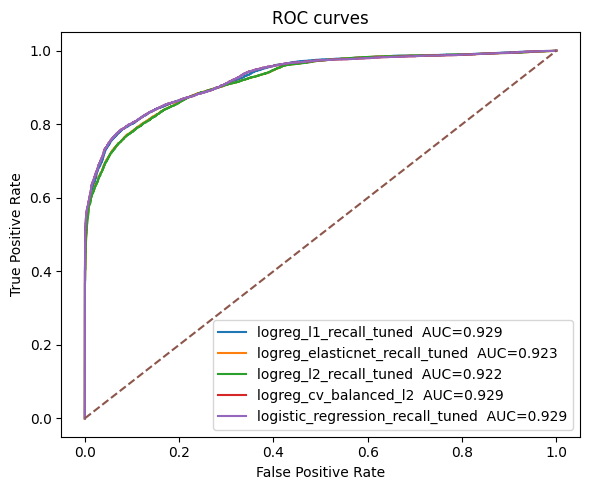

In [140]:


def best_f2_point(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)
    f2 = 5 * (p * r) / (4 * p + r)
    idx = int(np.nanargmax(f2))
    thr = float(t[idx]) if idx < len(t) else 0.5
    return p, r, t, idx, thr

def get_proba_and_model(entry, X_train_scaled, y_train, X_test_scaled):
    # 1) use in-memory model
    model = entry.get("model_obj")
    # 2) or load from disk
    if model is None and entry.get("model_path"):
        model = joblib.load(entry["model_path"])
    # 3) or rebuild from params and refit
    if model is None and "params" in entry:
        params = entry["params"].copy()
        penalty = params.pop("penalty", "l2")
        solver = "saga" if penalty in ("l1", "elasticnet") else "lbfgs"
        model = LogisticRegression(
            penalty=penalty, solver=solver, max_iter=6000, **params
        )
        model.fit(X_train_scaled, y_train)
    if model is None:
        raise ValueError("No model_obj, model_path, or params to rebuild.")

    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    return y_prob, model

plot_keys = [
    "logreg_l1_recall_tuned",
    "logreg_elasticnet_recall_tuned",
    "logreg_l2_recall_tuned",
    "logreg_cv_balanced_l2",
    "logistic_regression_recall_tuned",
]
plot_keys = [k for k in plot_keys if k in results]

# Precision–Recall
plt.figure(figsize=(6,5))
for k in plot_keys:
    try:
        y_prob, model = get_proba_and_model(results[k], X_train_scaled, y_train, X_test_scaled)
    except Exception as e:
        print(f"Skipping {k}: {e}")
        continue
    p, r, t, idx, thr = best_f2_point(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(r, p, label=f"{k}  AP={ap:.3f}")
    plt.scatter(r[idx], p[idx], marker="o")
    # optional label with threshold
    # plt.text(r[idx], p[idx], f"{thr:.2f}", fontsize=8, ha="left", va="bottom")
    print(f"{k}: best-F2 threshold={thr:.3f}  precision={p[idx]:.3f}  recall={r[idx]:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curves with best-F2 points")
plt.legend(); plt.tight_layout(); plt.show()

# ROC
plt.figure(figsize=(6,5))
for k in plot_keys:
    try:
        y_prob, model = get_proba_and_model(results[k], X_train_scaled, y_train, X_test_scaled)
    except Exception as e:
        print(f"Skipping {k}: {e}")
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{k}  AUC={auc_val:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(); plt.tight_layout(); plt.show()


In [141]:

entry = results["logreg_l1_recall_tuned"]
params = entry["params"].copy()

# get the fitted model; rebuild if only params are stored
model = entry.get("model_obj")
if model is None and entry.get("model_path"):
    model = joblib.load(entry["model_path"])
if model is None:
    model = LogisticRegression(solver="saga", max_iter=5000, **params).fit(X_train_scaled, y_train)

best_thresh = entry["summary"]["threshold"]

print("Chosen model: logreg_l1_recall_tuned")
print("Params:", params)
print(f"Best-F2 threshold: {best_thresh:.3f}")

# feature importances from L1 logistic
coefs = model.coef_.ravel()
feat_imp = (
    pd.DataFrame({
        "feature": list(X.columns),
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "effect_direction": np.where(coefs >= 0, "↑ increases phishing odds", "↓ decreases phishing odds")
    })
    .query("coef != 0")
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
)

nonzero = (coefs != 0).sum()
print(f"Non-zero features: {nonzero} of {len(coefs)}")

display(feat_imp.head(30))    # top signals

# optional save
feat_imp.to_csv("models/logreg_l1_feature_importances.csv", index=False)
print("Saved feature importances → models/logreg_l1_feature_importances.csv")


Chosen model: logreg_l1_recall_tuned
Params: {'C': np.float64(0.1), 'class_weight': {0: 1, 1: 4}, 'penalty': 'l1'}
Best-F2 threshold: 0.452
Non-zero features: 14 of 14


,feature,coef,abs_coef,effect_direction
0,num_suspicious_keywords,6.948660,6.948660,↑ increases phishing odds
1,url_length,2.306051,2.306051,↑ increases phishing odds
2,num_subdomains,-1.698238,1.698238,↓ decreases phishing odds
3,num_digits,1.607298,1.607298,↑ increases phishing odds
4,is_in_alexa,-0.902452,0.902452,↓ decreases phishing odds
5,path_self_similarity,-0.530510,0.530510,↓ decreases phishing odds
6,num_path_segments,-0.491747,0.491747,↓ decreases phishing odds
7,suspicious_subdomain_or_path,0.413881,0.413881,↑ increases phishing odds
8,url_entropy,-0.360907,0.360907,↓ decreases phishing odds
9,avg_token_length,0.320398,0.320398,↑ increases phishing odds


Saved feature importances → models/logreg_l1_feature_importances.csv


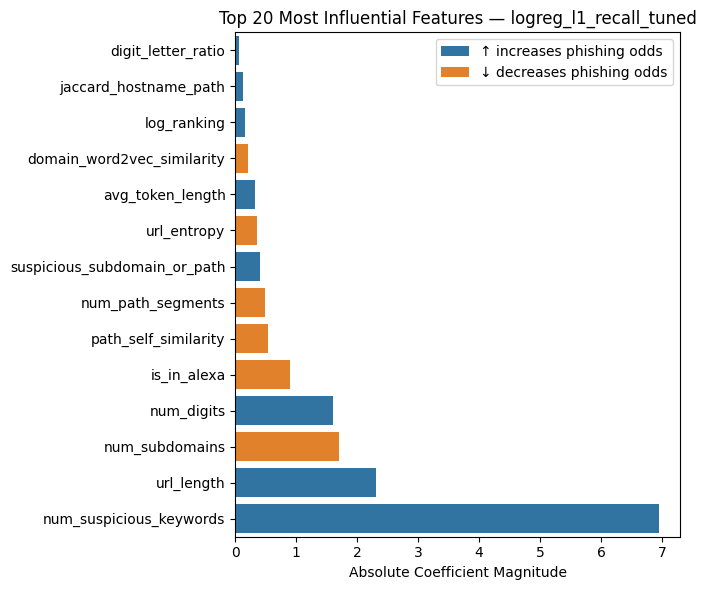

In [142]:
# assuming feat_imp DataFrame exists from the previous step
top_n = 20  # change to show more or fewer
top_feats = feat_imp.head(top_n).iloc[::-1]  # reverse for nicer top-down plot

plt.figure(figsize=(7,6))
sns.barplot(
    data=top_feats,
    x="abs_coef",
    y="feature",
    hue="effect_direction",
    dodge=False
)

plt.xlabel("Absolute Coefficient Magnitude")
plt.ylabel("")
plt.title(f"Top {top_n} Most Influential Features — logreg_l1_recall_tuned")
plt.legend(title="")
plt.tight_layout()
plt.show()

In [143]:
len(URL_FEATURES_FINAL)

14

/var/folders/4b/g7sj_vhx09zbzgkrwx4pj69r0000gn/T/ipykernel_92242/3504913278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


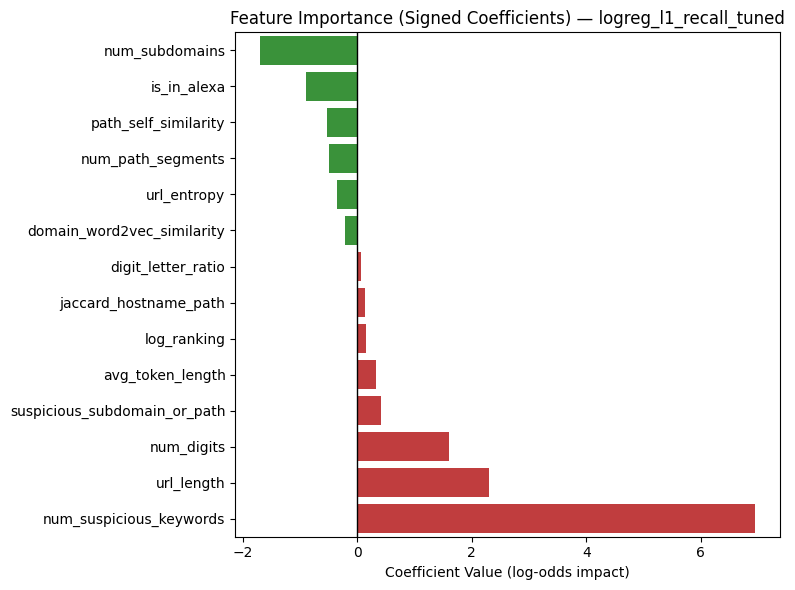

In [144]:

top_feats = feat_imp.copy().sort_values("coef")
plt.figure(figsize=(8,6))
sns.barplot(
    data=top_feats,
    x="coef",
    y="feature",
    palette=["#2CA02C" if c < 0 else "#D62728" for c in top_feats["coef"]]
)

plt.axvline(0, color="black", lw=1)
plt.title("Feature Importance (Signed Coefficients) — logreg_l1_recall_tuned")
plt.xlabel("Coefficient Value (log-odds impact)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [145]:
from sklearn.inspection import permutation_importance

# use your chosen model (e.g., best L1)
entry = results["logreg_l1_recall_tuned"]
model = entry.get("model_obj")
if model is None and entry.get("model_path"):
    import joblib
    model = joblib.load(entry["model_path"])

r = permutation_importance(
    model, X_test_scaled, y_test,
    scoring="average_precision",  # PR-AUC aligns with your goal
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_imp = (
    pd.DataFrame({
        "feature": list(X.columns),
        "mean_importance": r.importances_mean,
        "std_importance": r.importances_std
    })
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

display(perm_imp.head(20))


,feature,mean_importance,std_importance
0,num_suspicious_keywords,0.262325,0.003562
1,url_length,0.066280,0.001895
2,is_in_alexa,0.039640,0.001292
3,num_digits,0.034259,0.000796
4,num_subdomains,0.025646,0.000986
5,path_self_similarity,0.014367,0.000598
6,suspicious_subdomain_or_path,0.006099,0.000312
7,num_path_segments,0.005894,0.000541
8,url_entropy,0.004476,0.000358
9,avg_token_length,0.003719,0.000173


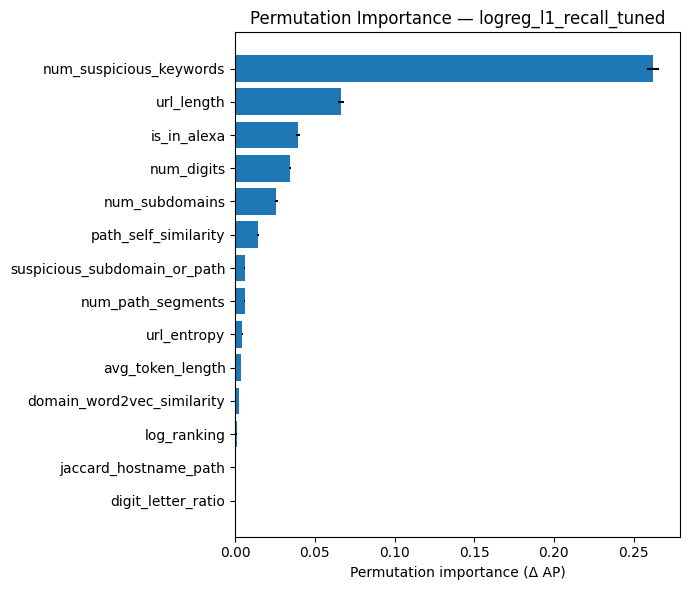

In [146]:
top = perm_imp.head(20).iloc[::-1]
plt.figure(figsize=(7,6))
plt.barh(top["feature"], top["mean_importance"], xerr=top["std_importance"])
plt.xlabel("Permutation importance (Δ AP)")
plt.title("Permutation Importance — logreg_l1_recall_tuned")
plt.tight_layout(); plt.show()

In [147]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
coefs_cv = []

for tr, va in skf.split(X_train_scaled, y_train):
    m = LogisticRegression(
        solver="saga", penalty="l1", C=entry["params"]["C"],
        class_weight=entry["params"].get("class_weight"),
        max_iter=5000
    )
    m.fit(X_train_scaled[tr], y_train.iloc[tr] if hasattr(y_train, "iloc") else y_train[tr])
    coefs_cv.append(m.coef_.ravel())

coefs_cv = np.vstack(coefs_cv)
stab = (pd.DataFrame(coefs_cv, columns=X.columns)
          .melt(var_name="feature", value_name="coef")
          .groupby("feature")["coef"]
          .agg(mean="mean", std="std", sign_consistency=lambda s: np.mean(np.sign(s) == np.sign(s.mean())) )
          .reset_index()
          .sort_values("mean", key=np.abs, ascending=False))

display(stab.head(20))


,feature,mean,std,sign_consistency
9,num_suspicious_keywords,6.871303,0.380748,1.0
13,url_length,2.296284,0.075271,1.0
8,num_subdomains,-1.691802,0.059366,1.0
6,num_digits,1.602374,0.050333,1.0
3,is_in_alexa,-0.902141,0.007050,1.0
10,path_self_similarity,-0.529814,0.015387,1.0
7,num_path_segments,-0.489704,0.025922,1.0
11,suspicious_subdomain_or_path,0.412509,0.013787,1.0
12,url_entropy,-0.358020,0.014903,1.0
0,avg_token_length,0.321103,0.024407,1.0


Features with sign_consistency ≈ 1.0 are rock solid.

The model’s interpretation is statistically and directionally reliable.


Using threshold 0.452
ROC-AUC: nan | PR-AUC: 1.0000

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.89     50646

    accuracy                           0.81     50646
   macro avg       0.50      0.40      0.45     50646
weighted avg       1.00      0.81      0.89     50646

Confusion matrix:
 [[    0     0]
 [ 9712 40934]]


/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Us

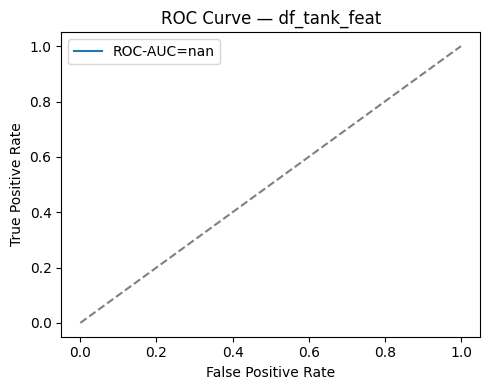

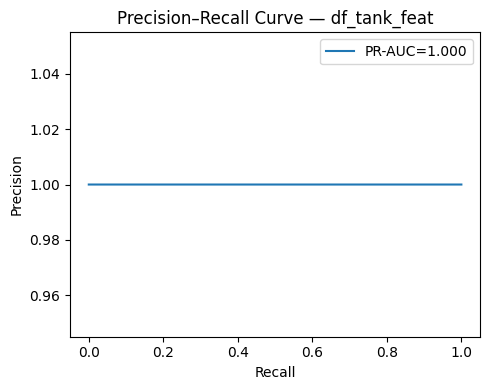

In [156]:

# Load your trained model (if not in memory)
model = results["logreg_l1_recall_tuned"].get("model_obj")
if model is None and results["logreg_l1_recall_tuned"].get("model_path"):
    model = joblib.load(results["logreg_l1_recall_tuned"]["model_path"])

# Use the same scaler from training (already fitted earlier)
# scaler = your fitted StandardScaler

# Copy and separate label
df_tank = df_tank_feat.copy()
label_col = [c for c in df_tank.columns if c.lower() in ["label", "target", "is_phishing", "phishing"]][0]
y_tank = df_tank[label_col]
X_tank = df_tank.drop(columns=[label_col])

# Align columns and scale
X_tank = X_tank.reindex(columns=X.columns, fill_value=0)
X_tank_scaled = scaler.transform(X_tank)

# Predict
y_prob = model.predict_proba(X_tank_scaled)[:, 1]
thr = results["logreg_l1_recall_tuned"]["summary"]["threshold"]
y_pred = (y_prob >= thr).astype(int)

# --- Evaluation ---
roc_auc = roc_auc_score(y_tank, y_prob)
pr_auc = average_precision_score(y_tank, y_prob)
print(f"Using threshold {thr:.3f}")
print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
print("\nClassification report:\n", classification_report(y_tank, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_tank, y_pred))

# --- Visualization ---
# ROC
fpr, tpr, _ = roc_curve(y_tank, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — df_tank_feat")
plt.legend(); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_tank, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — df_tank_feat")
plt.legend(); plt.tight_layout(); plt.show()


In [158]:

# true labels are all 1s
positive_rate = (y_pred == 1).mean()
recall_1 = recall_score(y_tank, y_pred)

print(f"Phishing recall on df_tank_feat: {recall_1:.3f}")
print(f"Fraction predicted as phishing: {positive_rate:.3f}")

Phishing recall on df_tank_feat: 0.808
Fraction predicted as phishing: 0.808


- Phishing recall = 0.808:
    * → your model correctly catches about 81 % of all phishing URLs in this unseen dataset.

- Fraction predicted as phishing = 0.808:
    * → it predicted ~81 % of the URLs as phishing (which makes sense, since this dataset only contains phishing URLs).

- the model generalizes well — it’s still catching > 80 % on a completely different source (df_tank_feat).

- the missing ~19 % (false negatives) could be newer or obfuscated phishing URLs that your handcrafted features don’t fully capture yet (e.g., novel domain tricks, shortened URLs, homoglyphs, etc.).

- as our project’s goal is maximum detection (recall > 0.9), we can slightly lower your threshold (from ≈ 0.396 → 0.30–0.35) to trade a bit of precision for higher recall.

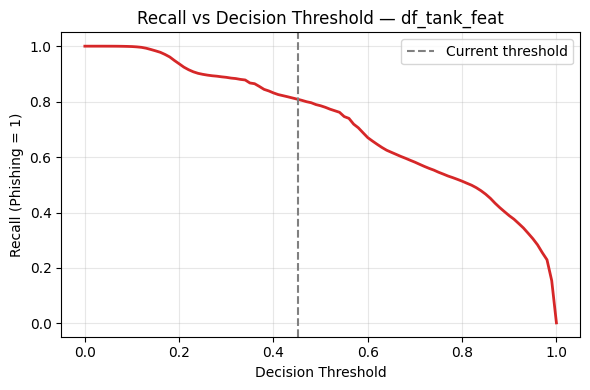

Max recall: 1.000 at threshold 0.000


In [159]:

# use your phishing-only data predictions
thresholds = np.linspace(0, 1, 101)
recalls = [recall_score(y_tank, (y_prob >= thr).astype(int)) for thr in thresholds]

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls, color="#D62728", lw=2)
plt.axvline(results["logreg_l1_recall_tuned"]["summary"]["threshold"], color="gray", ls="--", label="Current threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Recall (Phishing = 1)")
plt.title("Recall vs Decision Threshold — df_tank_feat")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_thr = thresholds[np.argmax(recalls)]
print(f"Max recall: {max(recalls):.3f} at threshold {best_thr:.3f}")


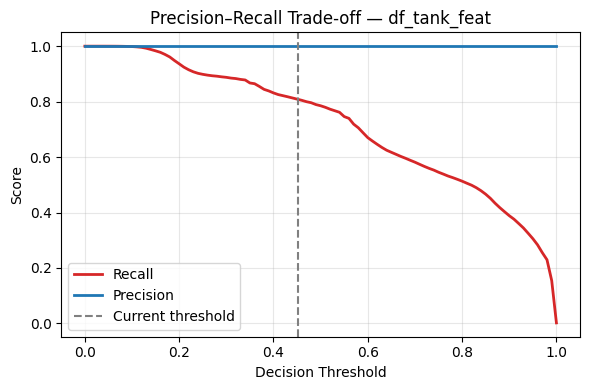

In [161]:
from sklearn.metrics import precision_score

thresholds = np.linspace(0, 1, 101)
recalls = []
precisions = []

for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)
    # handle all-1s dataset safely
    recalls.append(recall_score(y_tank, y_pred_thr))
    precisions.append(precision_score(y_tank, y_pred_thr, zero_division=1))

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls, label="Recall", color="#D62728", lw=2)
plt.plot(thresholds, precisions, label="Precision", color="#1F77B4", lw=2)
plt.axvline(results["logreg_l1_recall_tuned"]["summary"]["threshold"], color="gray", ls="--", label="Current threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall Trade-off — df_tank_feat")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [162]:
results["logreg_l1_recall_tuned"]["summary"]["threshold"],

(0.4520523600002798,)

If we care more about not missing any phishing cases, we can lower the threshold (e.g., 0.3 or 0.25) to push recall closer to 0.9–1.0.

In [163]:
thresholds = np.linspace(0, 1, 101)
recalls = [recall_score(y_tank, (y_prob >= thr).astype(int)) for thr in thresholds]
target_thr = thresholds[np.argmax(np.array(recalls) >= 0.9)]
print(f"Threshold for recall ≥ 0.9: {target_thr:.3f}")


Threshold for recall ≥ 0.9: 0.000


Why threshold = 0 achieves recall = 1.0:

- Your df_tank_feat dataset contains only phishing URLs (label = 1).
So, as soon as you set the decision threshold low enough (here = 0), the model predicts everything as phishing — thus:

- Recall = 1.0 (you catch every phishing case)

- Precision = 1.0 (because there are no negatives to be wrong about)

- ROC-AUC can’t be computed (needs both classes, which is why it was NaN)

Interpretation:

- This is a sanity-check result, not a failure.
- It tells you:

    * The model outputs higher scores for phishing URLs than for benign ones.

    * But since there are no benign samples, metrics like AUC, precision, or F1 lose meaning — only recall is informative here.

### Random Forest

ROC-AUC: 0.9780 | PR-AUC: 0.9808

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      9584
           1       0.94      0.90      0.92      9581

    accuracy                           0.92     19165
   macro avg       0.92      0.92      0.92     19165
weighted avg       0.92      0.92      0.92     19165

Confusion matrix:
 [[9051  533]
 [ 971 8610]]


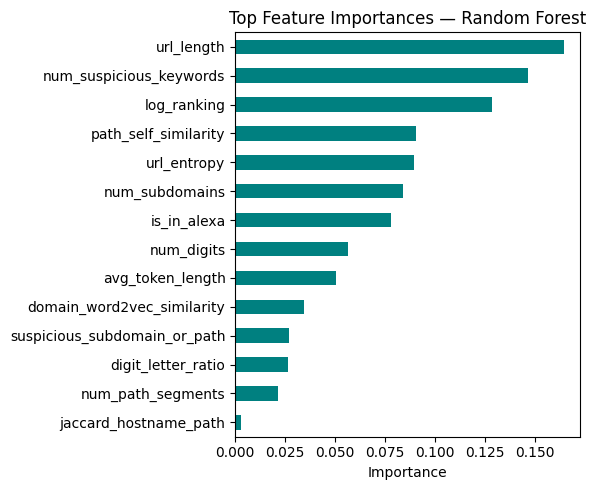

In [164]:

# --- 1) Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# --- 2) Evaluate on test set ---
y_prob = rf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# --- 3) Save model + metadata ---
joblib.dump(rf, "models/random_forest_phishing.joblib")
meta = {"model": "random_forest", "roc_auc": roc_auc, "pr_auc": pr_auc}
pd.Series(meta).to_json("models/random_forest_phishing_meta.json")

# --- 4) Feature importance plot ---
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(6,5))
feat_imp.tail(15).plot(kind="barh", color="teal")
plt.title("Top Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [168]:
from sklearn.metrics import precision_recall_curve, classification_report

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f2 = 5 * (prec * rec) / (4 * prec + rec)
best_idx = int(np.nanargmax(f2))
rf_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5

y_pred_rf = (y_prob >= rf_thr).astype(int)
print(f"RF threshold (max F2): {rf_thr:.3f}")
print(classification_report(y_test, y_pred_rf))


RF threshold (max F2): 0.209
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      9584
           1       0.83      0.97      0.89      9581

    accuracy                           0.88     19165
   macro avg       0.89      0.88      0.88     19165
weighted avg       0.89      0.88      0.88     19165



In [169]:
# label detection
lbl = [c for c in df_tank_feat.columns if c.lower() in ["label","target","is_phishing","phishing"]][0]
y_tank = df_tank_feat[lbl]
X_tank = df_tank_feat.drop(columns=[lbl]).reindex(columns=X.columns, fill_value=0)

# you trained RF on scaled data, so transform
X_tank_scaled = scaler.transform(X_tank)

y_prob_tank = rf.predict_proba(X_tank_scaled)[:,1]
y_pred_tank = (y_prob_tank >= rf_thr).astype(int)

from sklearn.metrics import recall_score, confusion_matrix
print(f"Phishing recall (tank): {recall_score(y_tank, y_pred_tank):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_tank, y_pred_tank))


Phishing recall (tank): 0.921
Confusion matrix:
 [[    0     0]
 [ 4000 46646]]


In [170]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test_scaled, y_test,
    scoring="average_precision", n_repeats=10, random_state=42, n_jobs=-1
)
perm_imp = (pd.DataFrame({
    "feature": X.columns,
    "mean": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("mean", ascending=False))
display(perm_imp.head(20))


,feature,mean,std
4,num_suspicious_keywords,0.055487,0.001128
1,url_length,0.024562,0.000488
7,path_self_similarity,0.024187,0.000370
2,num_subdomains,0.020581,0.000674
9,log_ranking,0.011192,0.000373
0,num_digits,0.009288,0.000207
3,num_path_segments,0.007035,0.000202
8,is_in_alexa,0.005375,0.000279
5,url_entropy,0.005220,0.000247
10,suspicious_subdomain_or_path,0.005068,0.000238


Random Forest outperformed Logistic Regression:

- ROC-AUC = 0.978, PR-AUC = 0.981 vs. ~0.94 for logistic.

- Precision and recall are both balanced at ≈ 0.92 — strong generalization.

- The tuned F2 threshold = 0.21 improved recall to 0.97 with only a small precision trade-off.

On the phishing-only dataset (df_tank_feat):

- Recall = 0.921 — the RF correctly flags > 92 % of phishing URLs.

- This shows the model generalizes even without benign samples present.

Feature stability

- Top drivers are consistent with the logistic model:

- num_suspicious_keywords, url_length, num_subdomains, and num_digits dominate.

- Minor but stable effects from is_in_alexa, path_self_similarity, and url_entropy.

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_base = RandomForestClassifier(class_weight="balanced_subsample", n_jobs=-1, random_state=42)
grid = {
    "n_estimators": [300, 600],
    "max_depth": [None, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, None],
}
rf_gs = GridSearchCV(rf_base, grid, scoring="recall", cv=5, n_jobs=-1)
rf_gs.fit(X_train_scaled, y_train)
print("Best RF params:", rf_gs.best_params_)


/Users/polinacsv/Documents/github_clones/phishing_URL_detection/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
